---
title: Introduction to Inference
author: Mark Fuge
date: 'October 22 2025'
format:
    html:
        code-fold: true
        code-summary: "Show Code"
---

**Learning Objectives**

By the end of this notebook, you will:

1. Understand **Bayesian inference for regression** and how it quantifies model uncertainty
2. Visualize the **posterior predictive distribution** for linear models
3. Recognize the **limitations of linear models** on nonlinear data
4. Learn how **neural networks** provide flexible nonlinear models
5. Understand why exact Bayesian inference becomes **intractable** for neural networks
6. Implement **Variational Inference (VI)** as an approximate solution
7. Compare VI to MCMC and understand the **speed vs. accuracy tradeoff**
8. Visualize **predictive uncertainty** in function space

**The Big Picture**

Imagine you have sparse sensor measurements from a mechanical system. You want to:

1. **Fit a model** that captures the underlying relationship
2. **Quantify uncertainty** in predictions (critical for safety-critical systems)
3. **Make predictions** with confidence intervals

This notebook shows you how to do this using **Bayesian inference**, starting with simple linear models and progressing to flexible neural networks where **variational inference** becomes essential.

## Motivation and Toy Problem Definition

Let's start with a fundamental question: **when you fit a model to data, how confident should you be in its predictions?**

In traditional machine learning, we find a single "best" set of parameters. But in engineering, we often need to know:
- How uncertain are we about the model?
- Where in the input space are predictions reliable?
- What happens if we had slightly different data?

**Bayesian inference** answers these questions by maintaining a **distribution over models** rather than picking a single one.

### The Dataset: Nonlinear Sensor Measurements

We'll use a simple nonlinear function to represent sensor data:
$$y = \sin(x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.1^2)$$

This represents, for example:
- Cyclic behavior (vibrations, temperatures, etc.)
- Noisy measurements
- Sparse observations (we won't measure everywhere)

We will be interested in understanding how the model can capture the uncertainty of its prediction.

In [1]:
# Setup and imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


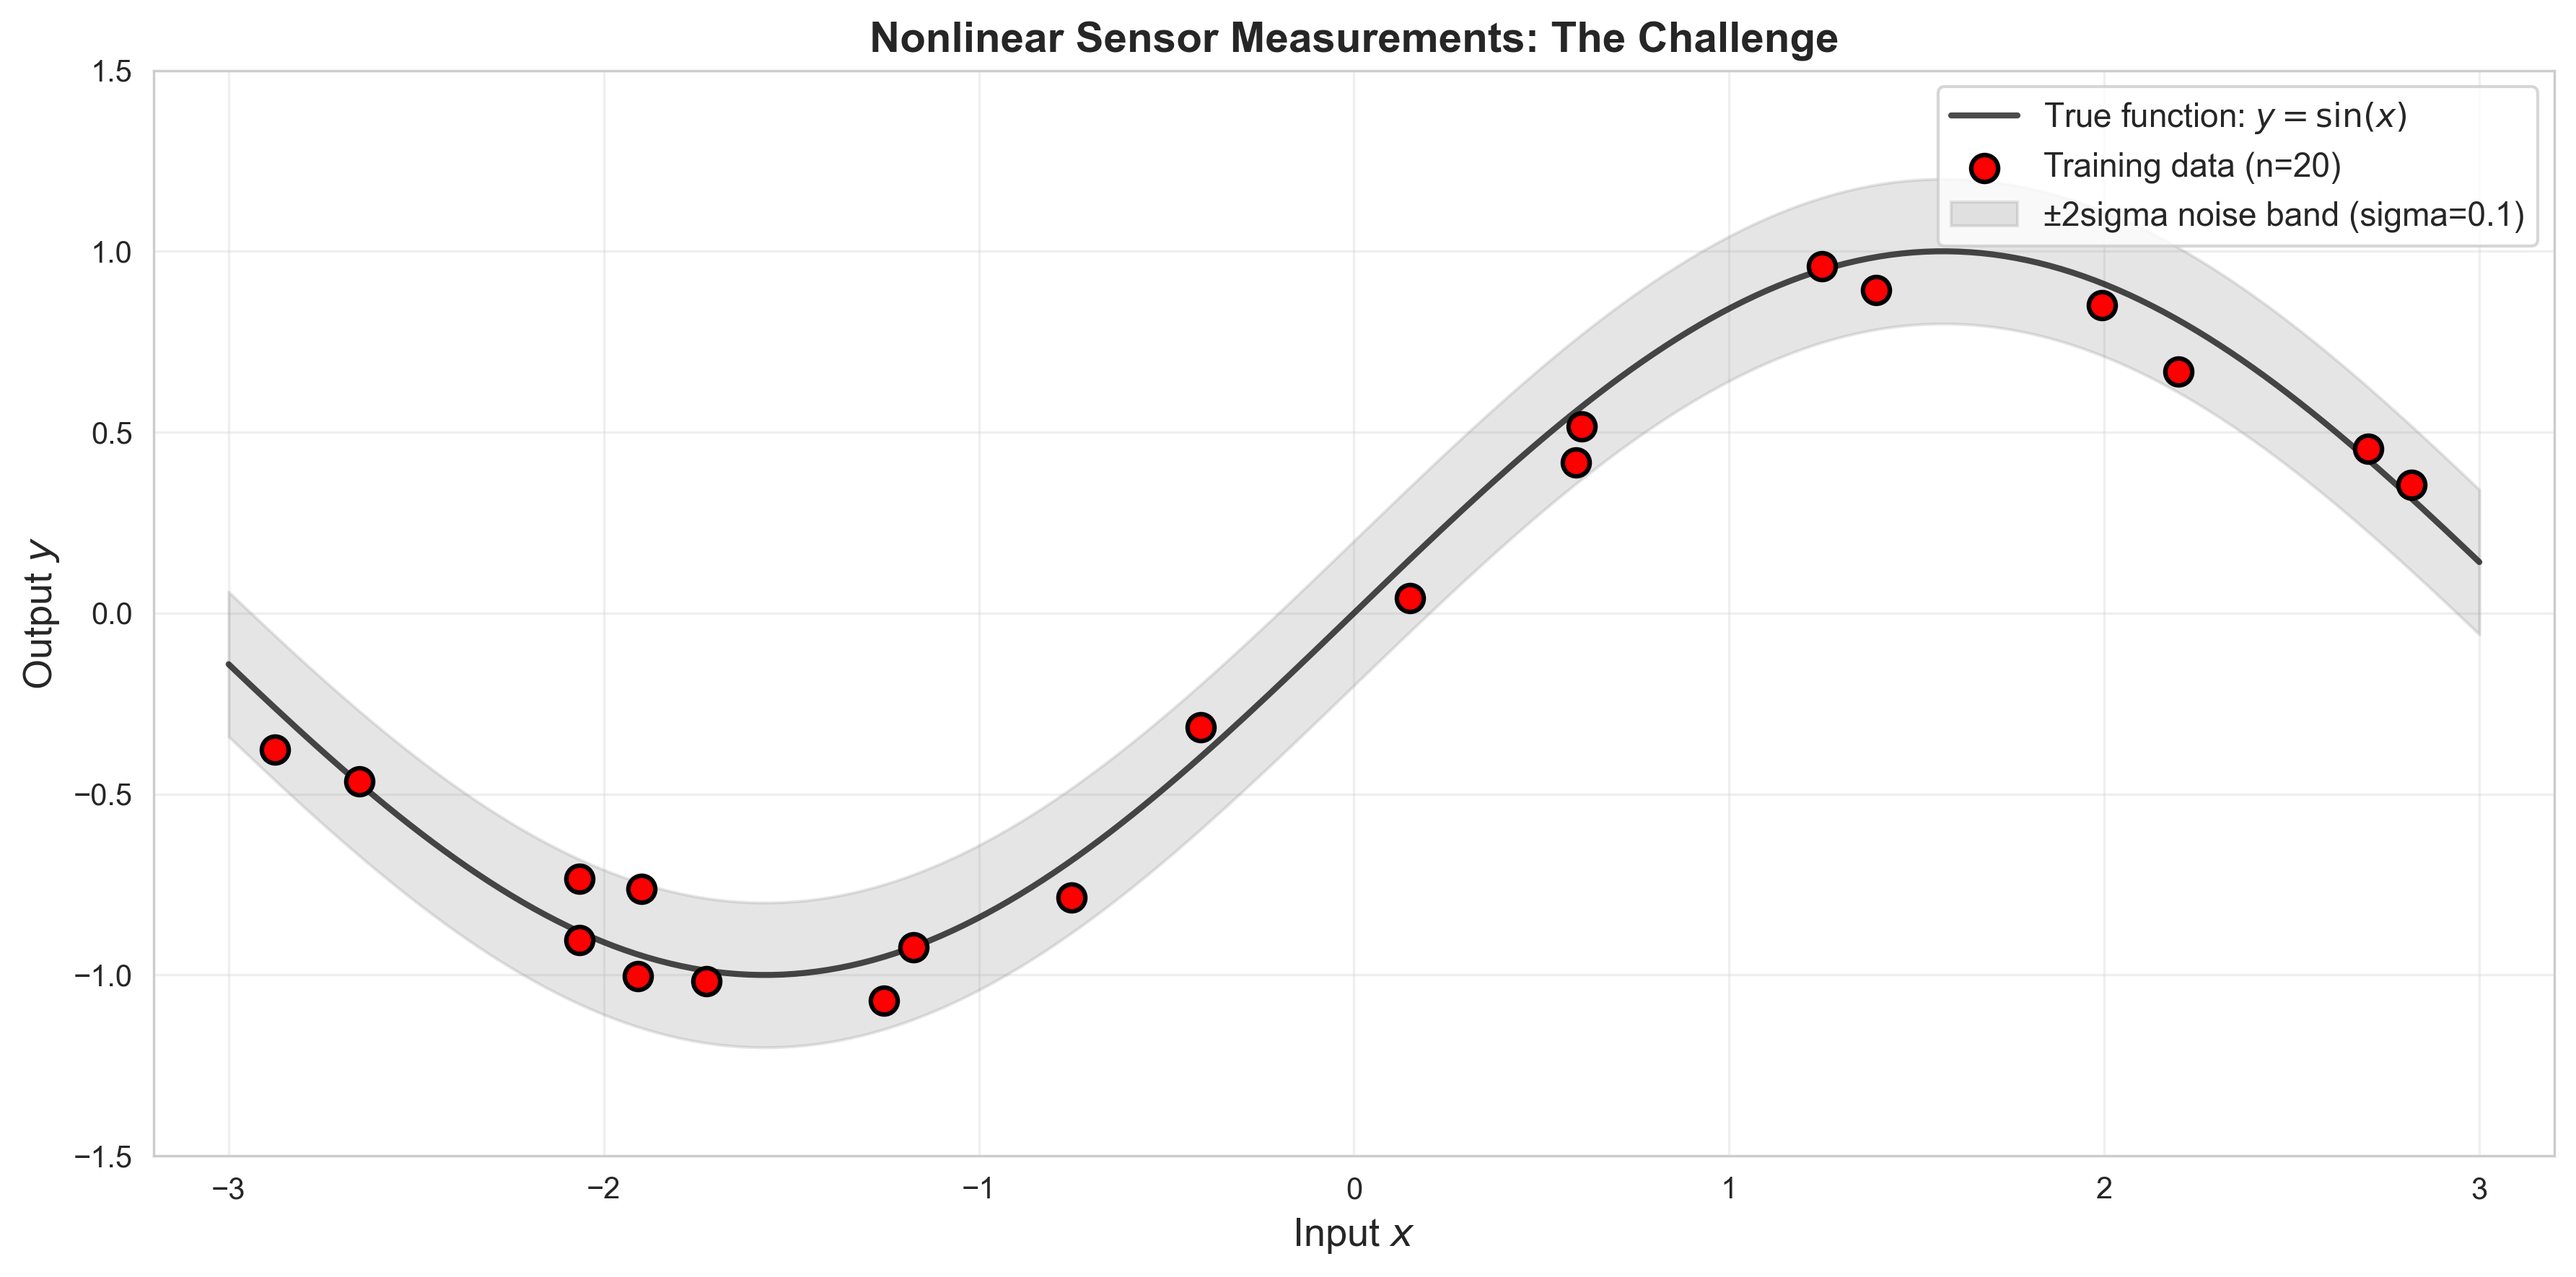

In [ ]:
# Generate nonlinear dataset
def generate_nonlinear_data(n_samples: int = 20, 
                           noise_std: float = 0.1,
                           x_range: Tuple[float, float] = (-3, 3)) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate sparse noisy samples from a sinusoidal function.
    
    This simulates sensor measurements from a cyclic process.
    
    Args:
        n_samples: Number of observations
        noise_std: Standard deviation of measurement noise
        x_range: Input domain (min, max)
        
    Returns:
        x: Input locations (n_samples,)
        y: Noisy measurements (n_samples,)
    """
    x_min, x_max = x_range
    
    # Sample input locations (sparse, irregular spacing)
    x = np.random.uniform(x_min, x_max, n_samples)
    
    # True underlying function (unknown to the model)
    y_true = np.sin(x)
    
    # Add measurement noise
    y = y_true + noise_std * np.random.randn(n_samples)
    
    # Sort for easier visualization
    sort_idx = np.argsort(x)
    x = x[sort_idx]
    y = y[sort_idx]
    
    return x, y

# Generate training data
n_train = 20
noise_std = 0.1
x_train, y_train = generate_nonlinear_data(n_train, noise_std)

# Create dense grid for visualization (the "true" function)
x_test = np.linspace(-3, 3, 200)
y_test_true = np.sin(x_test)

# Visualize the dataset
fig, ax = plt.subplots(figsize=(12, 6))

# Plot true function
ax.plot(x_test, y_test_true, 'k-', linewidth=2, label='True function: $y = \\sin(x)$', alpha=0.7)

# Plot noisy training observations
ax.scatter(x_train, y_train, s=80, c='red', edgecolors='black', 
           linewidth=1.5, zorder=5, label=f'Training data (n={n_train})')

# Shade noise region
ax.fill_between(x_test, y_test_true - 2*noise_std, y_test_true + 2*noise_std,
                alpha=0.2, color='gray', label=f'±2sigma noise band (sigma={noise_std})')

ax.set_xlabel('Input $x$', fontsize=13)
ax.set_ylabel('Output $y$', fontsize=13)
ax.set_title('Nonlinear Sensor Measurements', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([-3.2, 3.2])
ax.set_ylim([-1.5, 1.5])

plt.tight_layout()
plt.show()

## Linear Bayesian Regression

Let's start with the simplest approach: **linear regression with Bayesian inference**.

### The Model

We assume a linear relationship:
$$y = w_0 + w_1 x + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)$$

In Bayesian inference, we place a **prior** over the weights:
$$p(\mathbf{w}) = \mathcal{N}(\mathbf{0}, \alpha^{-1} \mathbf{I})$$

After seeing data $(X, Y)$, the **posterior** over weights is:
$$p(\mathbf{w} | X, Y) = \mathcal{N}(\mathbf{m}_N, \mathbf{S}_N)$$

where (for linear-Gaussian models, we can derive it exactly):
$$\mathbf{S}_N = (\alpha \mathbf{I} + \beta \mathbf{\Phi}^T \mathbf{\Phi})^{-1}$$
$$\mathbf{m}_N = \beta \mathbf{S}_N \mathbf{\Phi}^T \mathbf{y}$$

where $\beta = 1/\sigma^2$ is the noise precision and $\mathbf{\Phi}$ is the design matrix.

### The Posterior Predictive Distribution

For a new input $x_*$, the **predictive distribution** integrates over all possible weights:
$$p(y_* | x_*, X, Y) = \int p(y_* | x_*, \mathbf{w}) p(\mathbf{w} | X, Y) d\mathbf{w}$$

For linear-Gaussian models, this is also Gaussian:
$$p(y_* | x_*, X, Y) = \mathcal{N}(\mathbf{m}_N^T \phi(x_*), \sigma_N^2(x_*))$$

The variance $\sigma_N^2(x_*)$ tells us **how uncertain** we are about predictions at $x_*$.

Let's implement this and see what happens when applied to our non-linear data.

In [3]:
#| code-fold: false
class BayesianLinearRegression:
    """
    Bayesian linear regression with Gaussian prior and likelihood.
    
    Closed-form posterior over weights for polynomial basis functions.
    """
    
    def __init__(self, degree: int = 1, alpha: float = 1.0, beta: float = 100.0):
        """
        Args:
            degree: Degree of polynomial basis (1 = linear)
            alpha: Prior precision (inverse variance)
            beta: Noise precision (1/sigma^2)
        """
        self.degree = degree
        self.alpha = alpha
        self.beta = beta
        self.m_N = None  # Posterior mean
        self.S_N = None  # Posterior covariance
        
    def _design_matrix(self, x: np.ndarray) -> np.ndarray:
        """Compute polynomial design matrix."""
        x = x.reshape(-1, 1)
        Phi = np.concatenate([x**i for i in range(self.degree + 1)], axis=1)
        return Phi
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        """Compute posterior over weights given training data."""
        Phi = self._design_matrix(X)
        n_features = Phi.shape[1]
        
        # Posterior covariance
        self.S_N = np.linalg.inv(self.alpha * np.eye(n_features) + 
                                  self.beta * Phi.T @ Phi)
        
        # Posterior mean
        self.m_N = self.beta * self.S_N @ Phi.T @ y
        
        return self
    
    def predict(self, X_test: np.ndarray, return_std: bool = True):
        """
        Posterior predictive distribution.
        
        Returns:
            mean: Predictive mean
            std: Predictive standard deviation (if return_std=True)
        """
        Phi_test = self._design_matrix(X_test)
        
        # Predictive mean
        y_mean = Phi_test @ self.m_N
        
        if return_std:
            # Predictive variance (includes noise and weight uncertainty)
            y_var = 1.0/self.beta + np.sum(Phi_test @ self.S_N * Phi_test, axis=1)
            y_std = np.sqrt(y_var)
            return y_mean, y_std
        
        return y_mean
    
    def sample_weights(self, n_samples: int = 100) -> np.ndarray:
        """Sample weight vectors from posterior."""
        return np.random.multivariate_normal(self.m_N, self.S_N, size=n_samples)

# Fit linear Bayesian regression
blr = BayesianLinearRegression(degree=1, alpha=1.0, beta=1.0/noise_std**2)
blr.fit(x_train, y_train)

# Posterior predictive distribution
y_pred_mean, y_pred_std = blr.predict(x_test)

print("Linear Bayesian Regression Fitted!")
print(f"Posterior mean weights: {blr.m_N}")
print(f"Posterior std of weights: {np.sqrt(np.diag(blr.S_N))}")

Linear Bayesian Regression Fitted!
Posterior mean weights: [-0.07553835  0.33272507]
Posterior std of weights: [0.0225762  0.01242588]


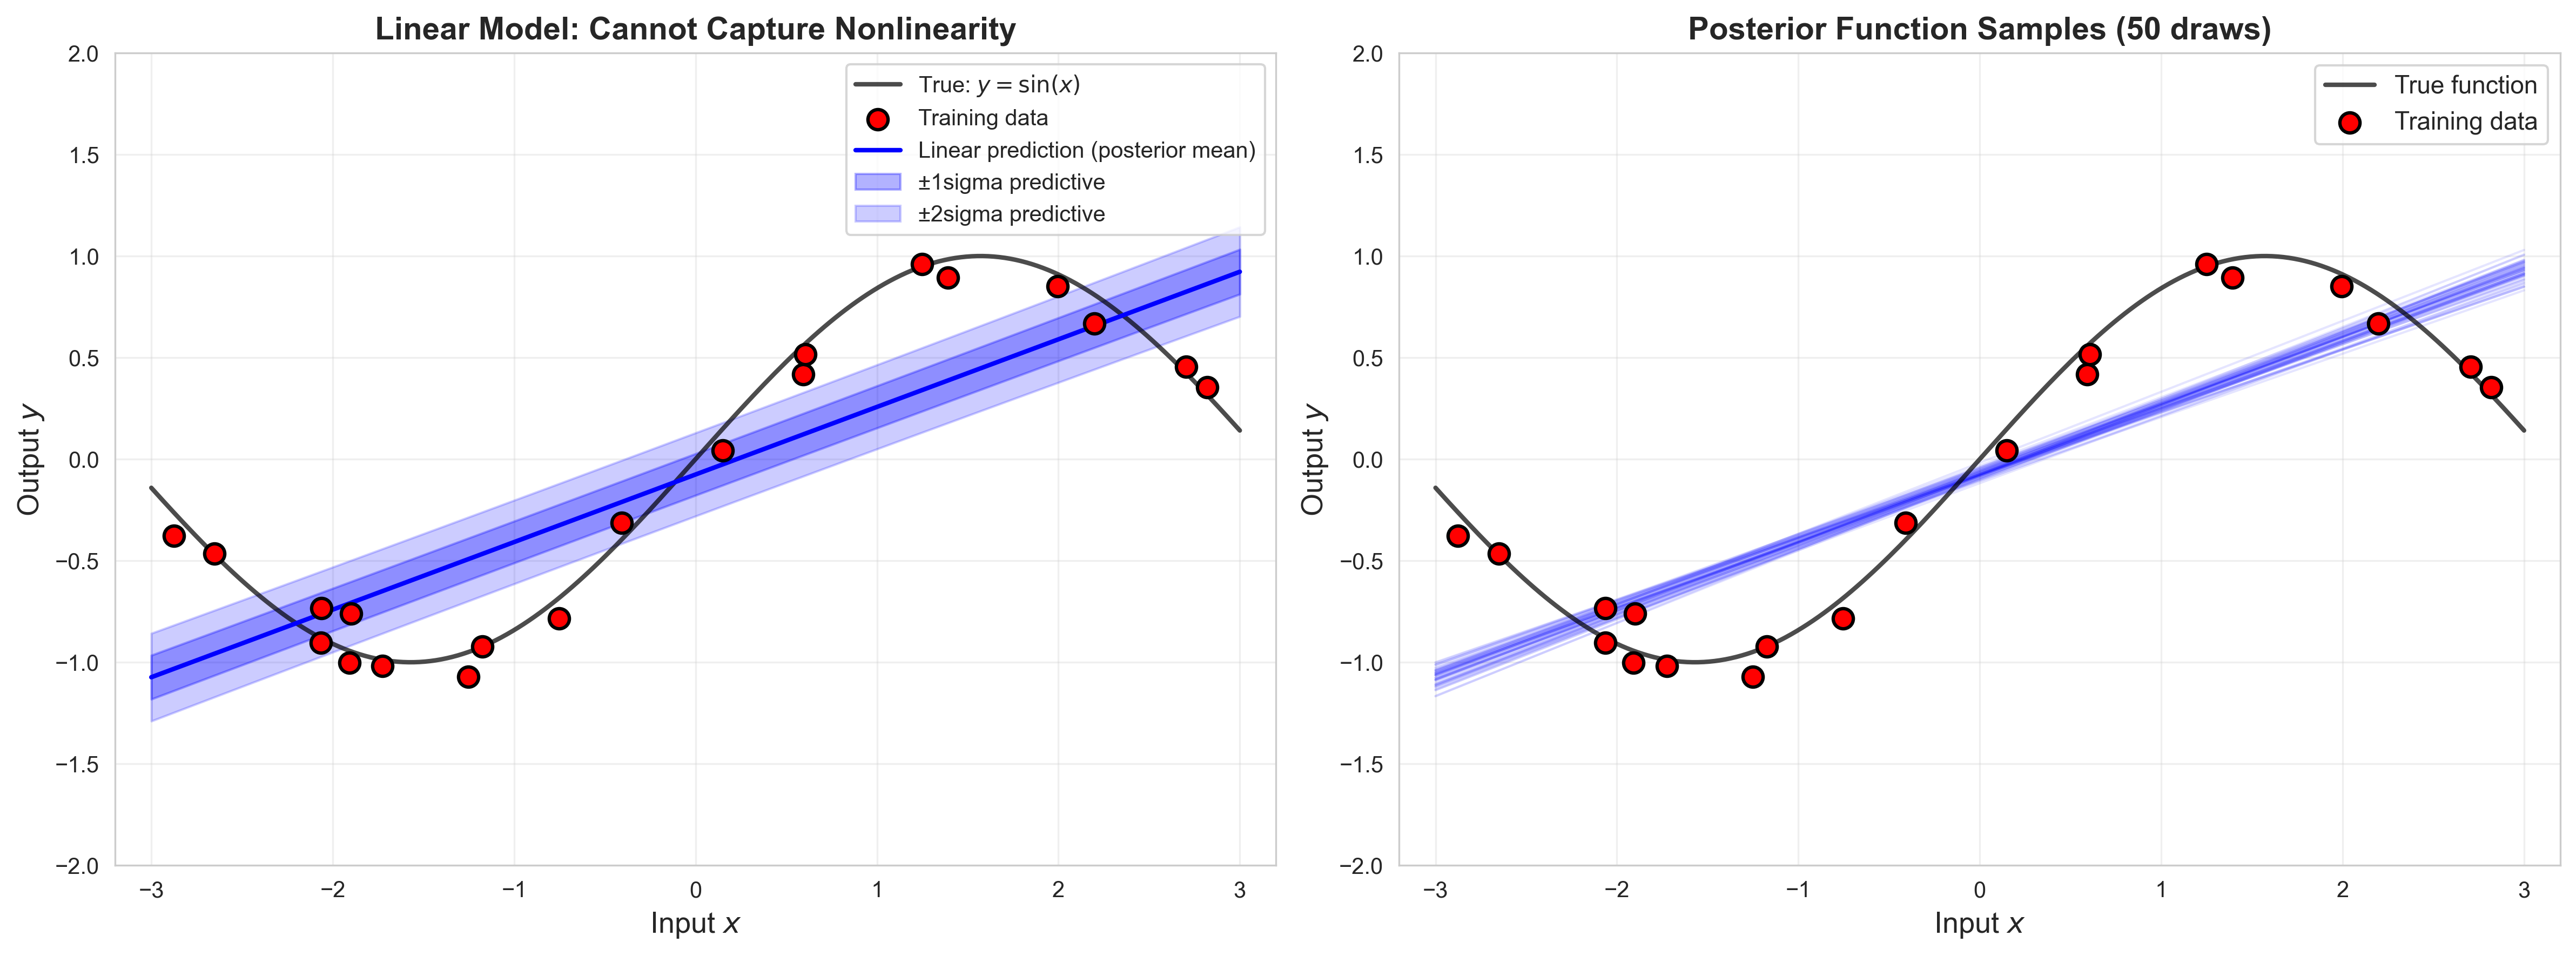

In [4]:
# Visualize linear Bayesian regression predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Posterior predictive with uncertainty bands
ax = axes[0]

# True function
ax.plot(x_test, y_test_true, 'k-', linewidth=2, label='True: $y = \\sin(x)$', alpha=0.7)

# Training data
ax.scatter(x_train, y_train, s=80, c='red', edgecolors='black', 
           linewidth=1.5, zorder=5, label='Training data')

# Predictive mean
ax.plot(x_test, y_pred_mean, 'b-', linewidth=2, label='Linear prediction (posterior mean)')

# Uncertainty bands (±1sigma and ±2sigma)
ax.fill_between(x_test, y_pred_mean - y_pred_std, y_pred_mean + y_pred_std,
                alpha=0.3, color='blue', label='±1sigma predictive')
ax.fill_between(x_test, y_pred_mean - 2*y_pred_std, y_pred_mean + 2*y_pred_std,
                alpha=0.2, color='blue', label='±2sigma predictive')

ax.set_xlabel('Input $x$', fontsize=13)
ax.set_ylabel('Output $y$', fontsize=13)
ax.set_title('Linear Model: Cannot Capture Nonlinearity', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([-3.2, 3.2])
ax.set_ylim([-2, 2])

# Plot 2: Function samples from posterior
ax = axes[1]

# Sample weight vectors and plot corresponding functions
w_samples = blr.sample_weights(n_samples=50)
Phi_test = np.concatenate([x_test.reshape(-1,1)**i for i in range(2)], axis=1)

for i in range(50):
    y_sample = Phi_test @ w_samples[i]
    ax.plot(x_test, y_sample, 'b-', alpha=0.1, linewidth=1)

# True function and data
ax.plot(x_test, y_test_true, 'k-', linewidth=2, label='True function', alpha=0.7)
ax.scatter(x_train, y_train, s=80, c='red', edgecolors='black', 
           linewidth=1.5, zorder=5, label='Training data')

ax.set_xlabel('Input $x$', fontsize=13)
ax.set_ylabel('Output $y$', fontsize=13)
ax.set_title('Posterior Function Samples (50 draws)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([-3.2, 3.2])
ax.set_ylim([-2, 2])

plt.tight_layout()
plt.show()

## A Small Neural Network (Nonlinear Model)

The linear model fails because the true function is nonlinear. What if we try to use a simple **neural network** instead?

### Architecture

We'll use a simple 1-hidden-layer network:
$$f(x; \mathbf{w}) = \mathbf{w}_2^T \sigma(\mathbf{w}_1 x + \mathbf{b}_1) + b_2$$

where $\sigma$ is ReLU activation. With just 5 hidden units, this can approximate smooth nonlinear functions.

### The New Challenge: Intractable Posterior

Unlike linear regression, the posterior $p(\mathbf{w} | X, Y)$ is **no longer Gaussian**! We cannot compute it analytically.

However, we can still:
1. Define a **prior** $p(\mathbf{w})$ (e.g., Gaussian on all weights)
2. Sample functions from the prior to see what kinds of functions are admissible under the model
3. Later, we can use **VI or MCMC** to approximate the posterior

Let's first see what the **prior predictive distribution** looks like.

In [5]:
#| code-fold: false
class SmallNN(nn.Module):
    """
    Simple 1-hidden-layer neural network for regression.
    """
    
    def __init__(self, hidden_size: int = 5):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = x.view(-1, 1)
        h = F.relu(self.fc1(x))
        y = self.fc2(h)
        return y.squeeze()
    
    def get_weights_flat(self) -> torch.Tensor:
        """Get all weights as a flat vector."""
        return torch.cat([p.flatten() for p in self.parameters()])
    
    def set_weights_flat(self, w_flat: torch.Tensor):
        """Set all weights from a flat vector."""
        offset = 0
        for p in self.parameters():
            n_params = p.numel()
            p.data = w_flat[offset:offset+n_params].view(p.shape)
            offset += n_params

# Create network and count parameters
hidden_size = 5
model = SmallNN(hidden_size=hidden_size)
n_params = sum(p.numel() for p in model.parameters())

print("Neural Network Architecture:")
print(f"  Input → {hidden_size} hidden (ReLU) → 1 output")
print(f"  Total parameters: {n_params}")
print("Parameter breakdown:")
for name, param in model.named_parameters():
    print(f"  {name}: shape {param.shape}, count {param.numel()}")

Neural Network Architecture:
  Input → 5 hidden (ReLU) → 1 output
  Total parameters: 16
Parameter breakdown:
  fc1.weight: shape torch.Size([5, 1]), count 5
  fc1.bias: shape torch.Size([5]), count 5
  fc2.weight: shape torch.Size([1, 5]), count 5
  fc2.bias: shape torch.Size([1]), count 1


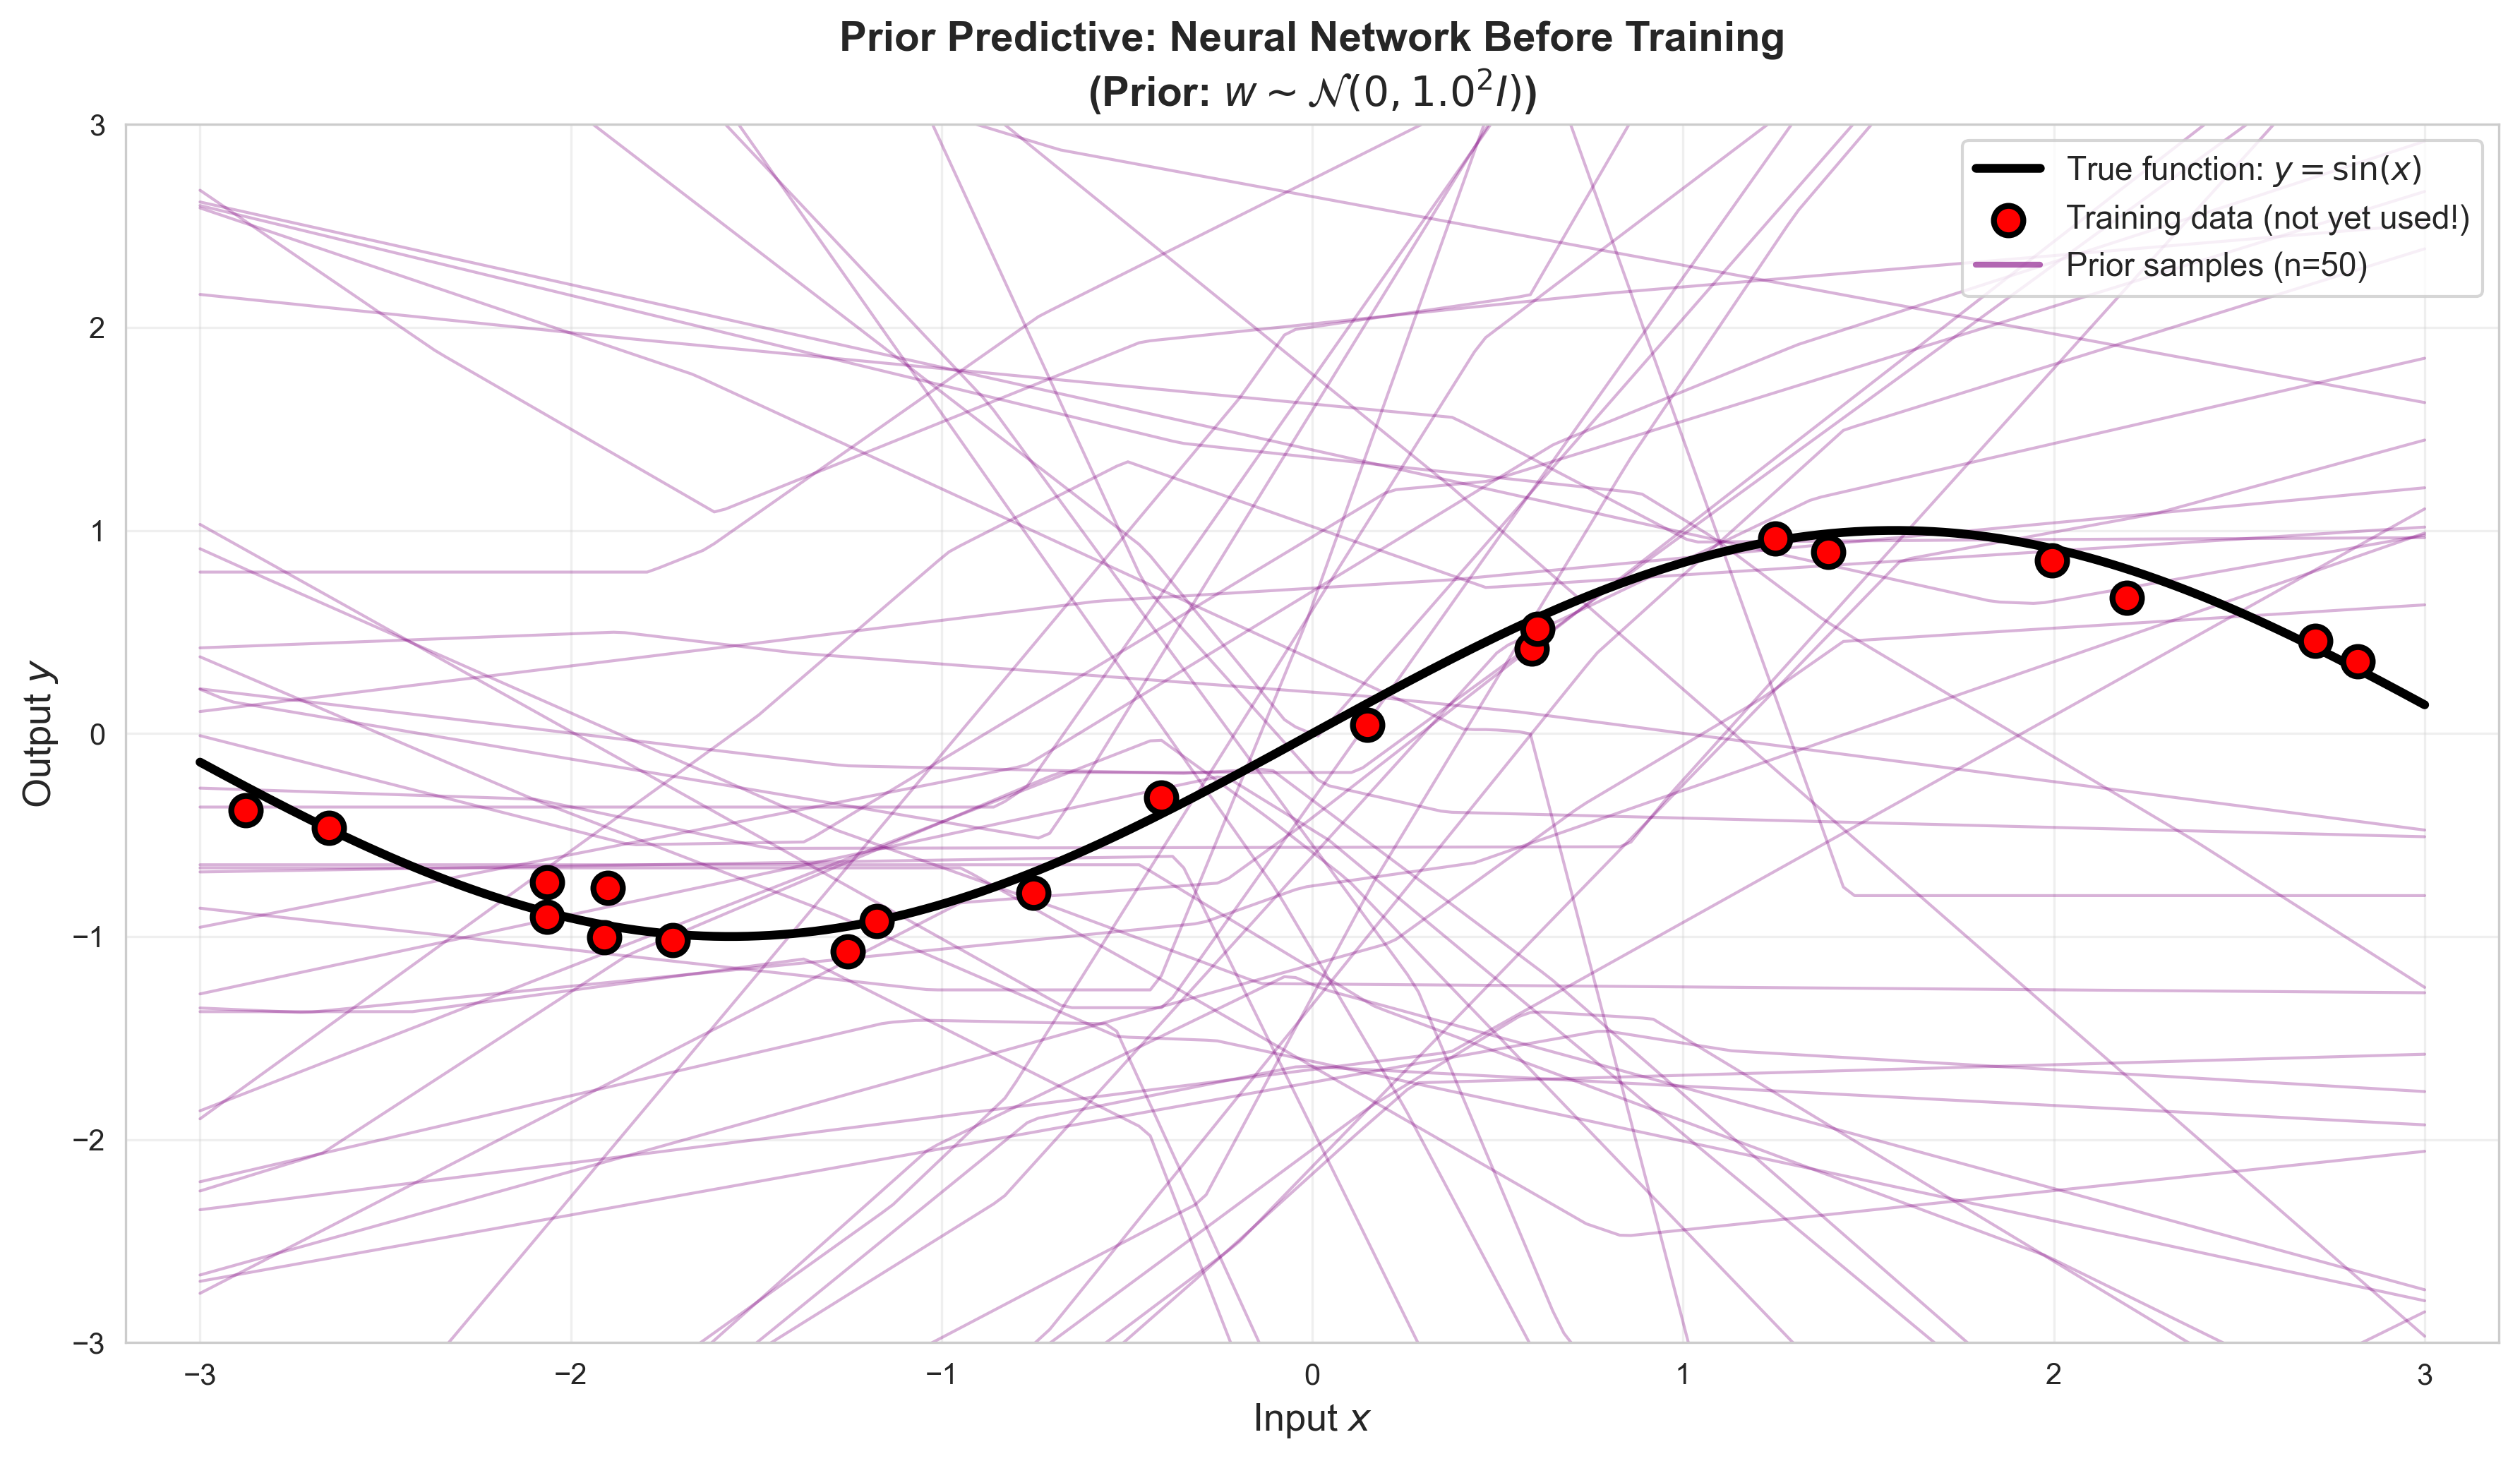

In [6]:
# Sample functions from the PRIOR (before seeing any data)
def sample_prior_functions(model, x_test, n_samples=20, prior_std=1.0):
    """
    Sample function predictions from prior p(w) = N(0, prior_std^2 * I).
    """
    x_test_tensor = torch.FloatTensor(x_test)
    predictions = []
    
    with torch.no_grad():
        for _ in range(n_samples):
            # Sample weights from prior
            for param in model.parameters():
                param.data.normal_(0, prior_std)
            
            # Forward pass
            y_pred = model(x_test_tensor).numpy()
            predictions.append(y_pred)
    
    return np.array(predictions)

# Generate prior predictive samples
prior_std = 1.0
n_prior_samples = 50
prior_predictions = sample_prior_functions(model, x_test, n_prior_samples, prior_std)

# Visualize prior predictive distribution
fig, ax = plt.subplots(figsize=(12, 7))

# Plot prior function samples
for i in range(n_prior_samples):
    ax.plot(x_test, prior_predictions[i], 'purple', alpha=0.3, linewidth=1)

# Plot true function and data
ax.plot(x_test, y_test_true, 'k-', linewidth=3, label='True function: $y = \\sin(x)$', zorder=10)
ax.scatter(x_train, y_train, s=100, c='red', edgecolors='black', 
           linewidth=2, zorder=15, label='Training data (not yet used!)')

# Add dummy line for legend
ax.plot([], [], 'purple', alpha=0.6, linewidth=2, 
        label=f'Prior samples (n={n_prior_samples})')

ax.set_xlabel('Input $x$', fontsize=13)
ax.set_ylabel('Output $y$', fontsize=13)
ax.set_title(f'Prior Predictive: Neural Network Before Training\n(Prior: $w \\sim \\mathcal{{N}}(0, {prior_std}^2 I)$)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([-3.2, 3.2])
ax.set_ylim([-3, 3])

plt.tight_layout()
plt.show()

We can see that just sampling functions from the prior, the possible Neural Network functions are a lot more diverse that those we could sample from the linear model. But how do we find out which of these weights are (probabilistically) likely?

## MCMC Approximation

The neural network posterior $p(\mathbf{w} | X, Y)$ is intractable, but we can **sample** from it using **Markov Chain Monte Carlo (MCMC)**.

### What is MCMC?

MCMC methods (like Hamiltonian Monte Carlo) generate samples $\mathbf{w}^{(1)}, \mathbf{w}^{(2)}, \ldots$ from the posterior by:
1. Starting at a random initial weight vector
2. Proposing updated samples that respect the posterior density
3. Eventually converging to samples from $p(\mathbf{w} | X, Y)$

So, in a nutshell, it allows you to generate plausible samples from $p(\mathbf{w} | X, Y)$ without ever having to strictly compute the posterior.

**Pros**: Asymptotically exact (given infinite samples)  
**Cons**: Slow, especially for high-dimensional models

For our small network, MCMC is feasible. We will use it as a reference to compare against variational inference at the end of this notebook.

### Note on Implementation

For this notebook, we'll use a simple **Metropolis-Hastings** sampler. In practice, you'd use more sophisticated methods like:
- Hamiltonian Monte Carlo (HMC) via PyTorch or PyMC
- No-U-Turn Sampler (NUTS)
- Stochastic Gradient Langevin Dynamics (SGLD)

which we may cover in later notebooks. For an interactive example of samplers, I highly recommend checking out the [MCMC Interactive Gallery](https://chi-feng.github.io/mcmc-demo/app.html)

#### The Metropolis-Hastings Algorithm

The algorithm works as follows:

1. **Initialize**: Start with random weights $\mathbf{w}^{(0)}$
2. **Propose**: Generate a candidate $\mathbf{w}^* \sim q(\mathbf{w}^* | \mathbf{w}^{(t)})$ (typically a Gaussian centered at current weights)
3. **Accept/Reject**: Compute the acceptance probability:
    $$\alpha = \min\left(1, \frac{p(\mathbf{w}^* | X, Y)}{p(\mathbf{w}^{(t)} | X, Y)}\right) = \min\left(1, \frac{p(Y | X, \mathbf{w}^*) p(\mathbf{w}^*)}{p(Y | X, \mathbf{w}^{(t)}) p(\mathbf{w}^{(t)})}\right)$$
    Accept $\mathbf{w}^{(t+1)} = \mathbf{w}^*$ with probability $\alpha$, otherwise keep $\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)}$
4. **Repeat**: Continue for many iterations until the chain converges

The useful thing about this sampler (and indeed MCMC approaches in general), is that we only ever need to evaluate the **unnormalized** posterior (likelihood × prior), and thus can avoid computing the intractable normalizing constant.

**Key parameters to tune**:
- **Proposal standard deviation**: Too large → low acceptance rate; too small → slow exploration
- **Burn-in**: Discard early samples before convergence
- **Thinning**: Keep every $k$-th sample to reduce autocorrelation

For our 16-parameter network, this is tractable. For modern deep networks with millions of parameters, MCMC becomes prohibitively slow and this is where variational inference can come to the rescue, as we will see later.


In [7]:
#| code-fold: false
# Simple MCMC sampler for neural network weights
def log_likelihood(model, x, y, noise_std=0.1):
    """Compute log p(y|x,w) for current weights."""
    with torch.no_grad():
        x_tensor = torch.FloatTensor(x)
        y_pred = model(x_tensor).numpy()
        log_lik = -0.5 * np.sum(((y - y_pred) / noise_std) ** 2)
        log_lik -= len(y) * np.log(noise_std * np.sqrt(2 * np.pi))
    return log_lik

def log_prior(model, prior_std=1.0):
    """Compute log p(w) for current weights."""
    log_p = 0
    for param in model.parameters():
        log_p -= 0.5 * torch.sum((param / prior_std) ** 2).item()
    return log_p

def metropolis_hastings_nn(x_train, y_train, n_samples=5000, proposal_std=0.01,
                           prior_std=1.0, noise_std=0.1, thin=10):
    """
    Simple Metropolis-Hastings MCMC for neural network weights.
    
    Args:
        thin: Only keep every 'thin'-th sample to reduce autocorrelation
    
    Returns:
        weight_samples: List of weight vectors
        acceptance_rate: Fraction of proposals accepted
    """
    model = SmallNN(hidden_size=5)
    
    # Initialize at MAP estimate (rough approximation: just train briefly)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    x_tensor = torch.FloatTensor(x_train).view(-1, 1)
    y_tensor = torch.FloatTensor(y_train)
    
    print("Finding initial weights (quick MAP estimate)...")
    for _ in range(200):
        optimizer.zero_grad()
        loss = F.mse_loss(model(x_tensor.squeeze()), y_tensor)
        loss.backward()
        optimizer.step()
    
    print(f"Starting MCMC sampling ({n_samples} iterations)...")
    
    # Current state
    current_log_posterior = log_likelihood(model, x_train, y_train, noise_std) + \
                            log_prior(model, prior_std)
    
    weight_samples = []
    n_accepted = 0
    
    for i in range(n_samples):
        # Propose new weights
        proposed_model = SmallNN(hidden_size=5)
        with torch.no_grad():
            for p_curr, p_prop in zip(model.parameters(), proposed_model.parameters()):
                p_prop.data = p_curr.data + proposal_std * torch.randn_like(p_curr)
        
        # Compute proposed log posterior
        proposed_log_posterior = log_likelihood(proposed_model, x_train, y_train, noise_std) + \
                                  log_prior(proposed_model, prior_std)
        
        # Accept/reject
        log_alpha = proposed_log_posterior - current_log_posterior
        if np.log(np.random.rand()) < log_alpha:
            # Accept
            model = proposed_model
            current_log_posterior = proposed_log_posterior
            n_accepted += 1
        
        # Store sample (with thinning)
        if i % thin == 0:
            weight_samples.append(model.get_weights_flat().clone().detach().numpy())
        
        if (i + 1) % 2000 == 0:
            acc_rate = n_accepted / (i + 1)
            print(f"  Iteration {i+1}/{n_samples}, acceptance rate: {acc_rate:.3f}")
    
    acceptance_rate = n_accepted / n_samples
    print(f"MCMC complete! Final acceptance rate: {acceptance_rate:.3f}")
    
    return weight_samples, acceptance_rate

# Run MCMC (this will take a minute or two)
print("Running MCMC to sample from posterior p(w|X,Y)...")
print("This may take 1-2 minutes for accurate results.")
mcmc_samples, acc_rate = metropolis_hastings_nn(
    x_train, y_train, 
    n_samples=10000, 
    proposal_std=0.010,
    prior_std=1.0,
    noise_std=noise_std,
    thin=10
)

print(f"Collected {len(mcmc_samples)} posterior samples (after thinning)")
print(f"Acceptance rate: {acc_rate:.1%}")

Running MCMC to sample from posterior p(w|X,Y)...
This may take 1-2 minutes for accurate results.
Finding initial weights (quick MAP estimate)...
Starting MCMC sampling (10000 iterations)...
Finding initial weights (quick MAP estimate)...
Starting MCMC sampling (10000 iterations)...
  Iteration 2000/10000, acceptance rate: 0.460
  Iteration 2000/10000, acceptance rate: 0.460
  Iteration 4000/10000, acceptance rate: 0.458
  Iteration 4000/10000, acceptance rate: 0.458
  Iteration 6000/10000, acceptance rate: 0.462
  Iteration 6000/10000, acceptance rate: 0.462
  Iteration 8000/10000, acceptance rate: 0.466
  Iteration 8000/10000, acceptance rate: 0.466
  Iteration 10000/10000, acceptance rate: 0.455
MCMC complete! Final acceptance rate: 0.455
Collected 1000 posterior samples (after thinning)
Acceptance rate: 45.5%
  Iteration 10000/10000, acceptance rate: 0.455
MCMC complete! Final acceptance rate: 0.455
Collected 1000 posterior samples (after thinning)
Acceptance rate: 45.5%


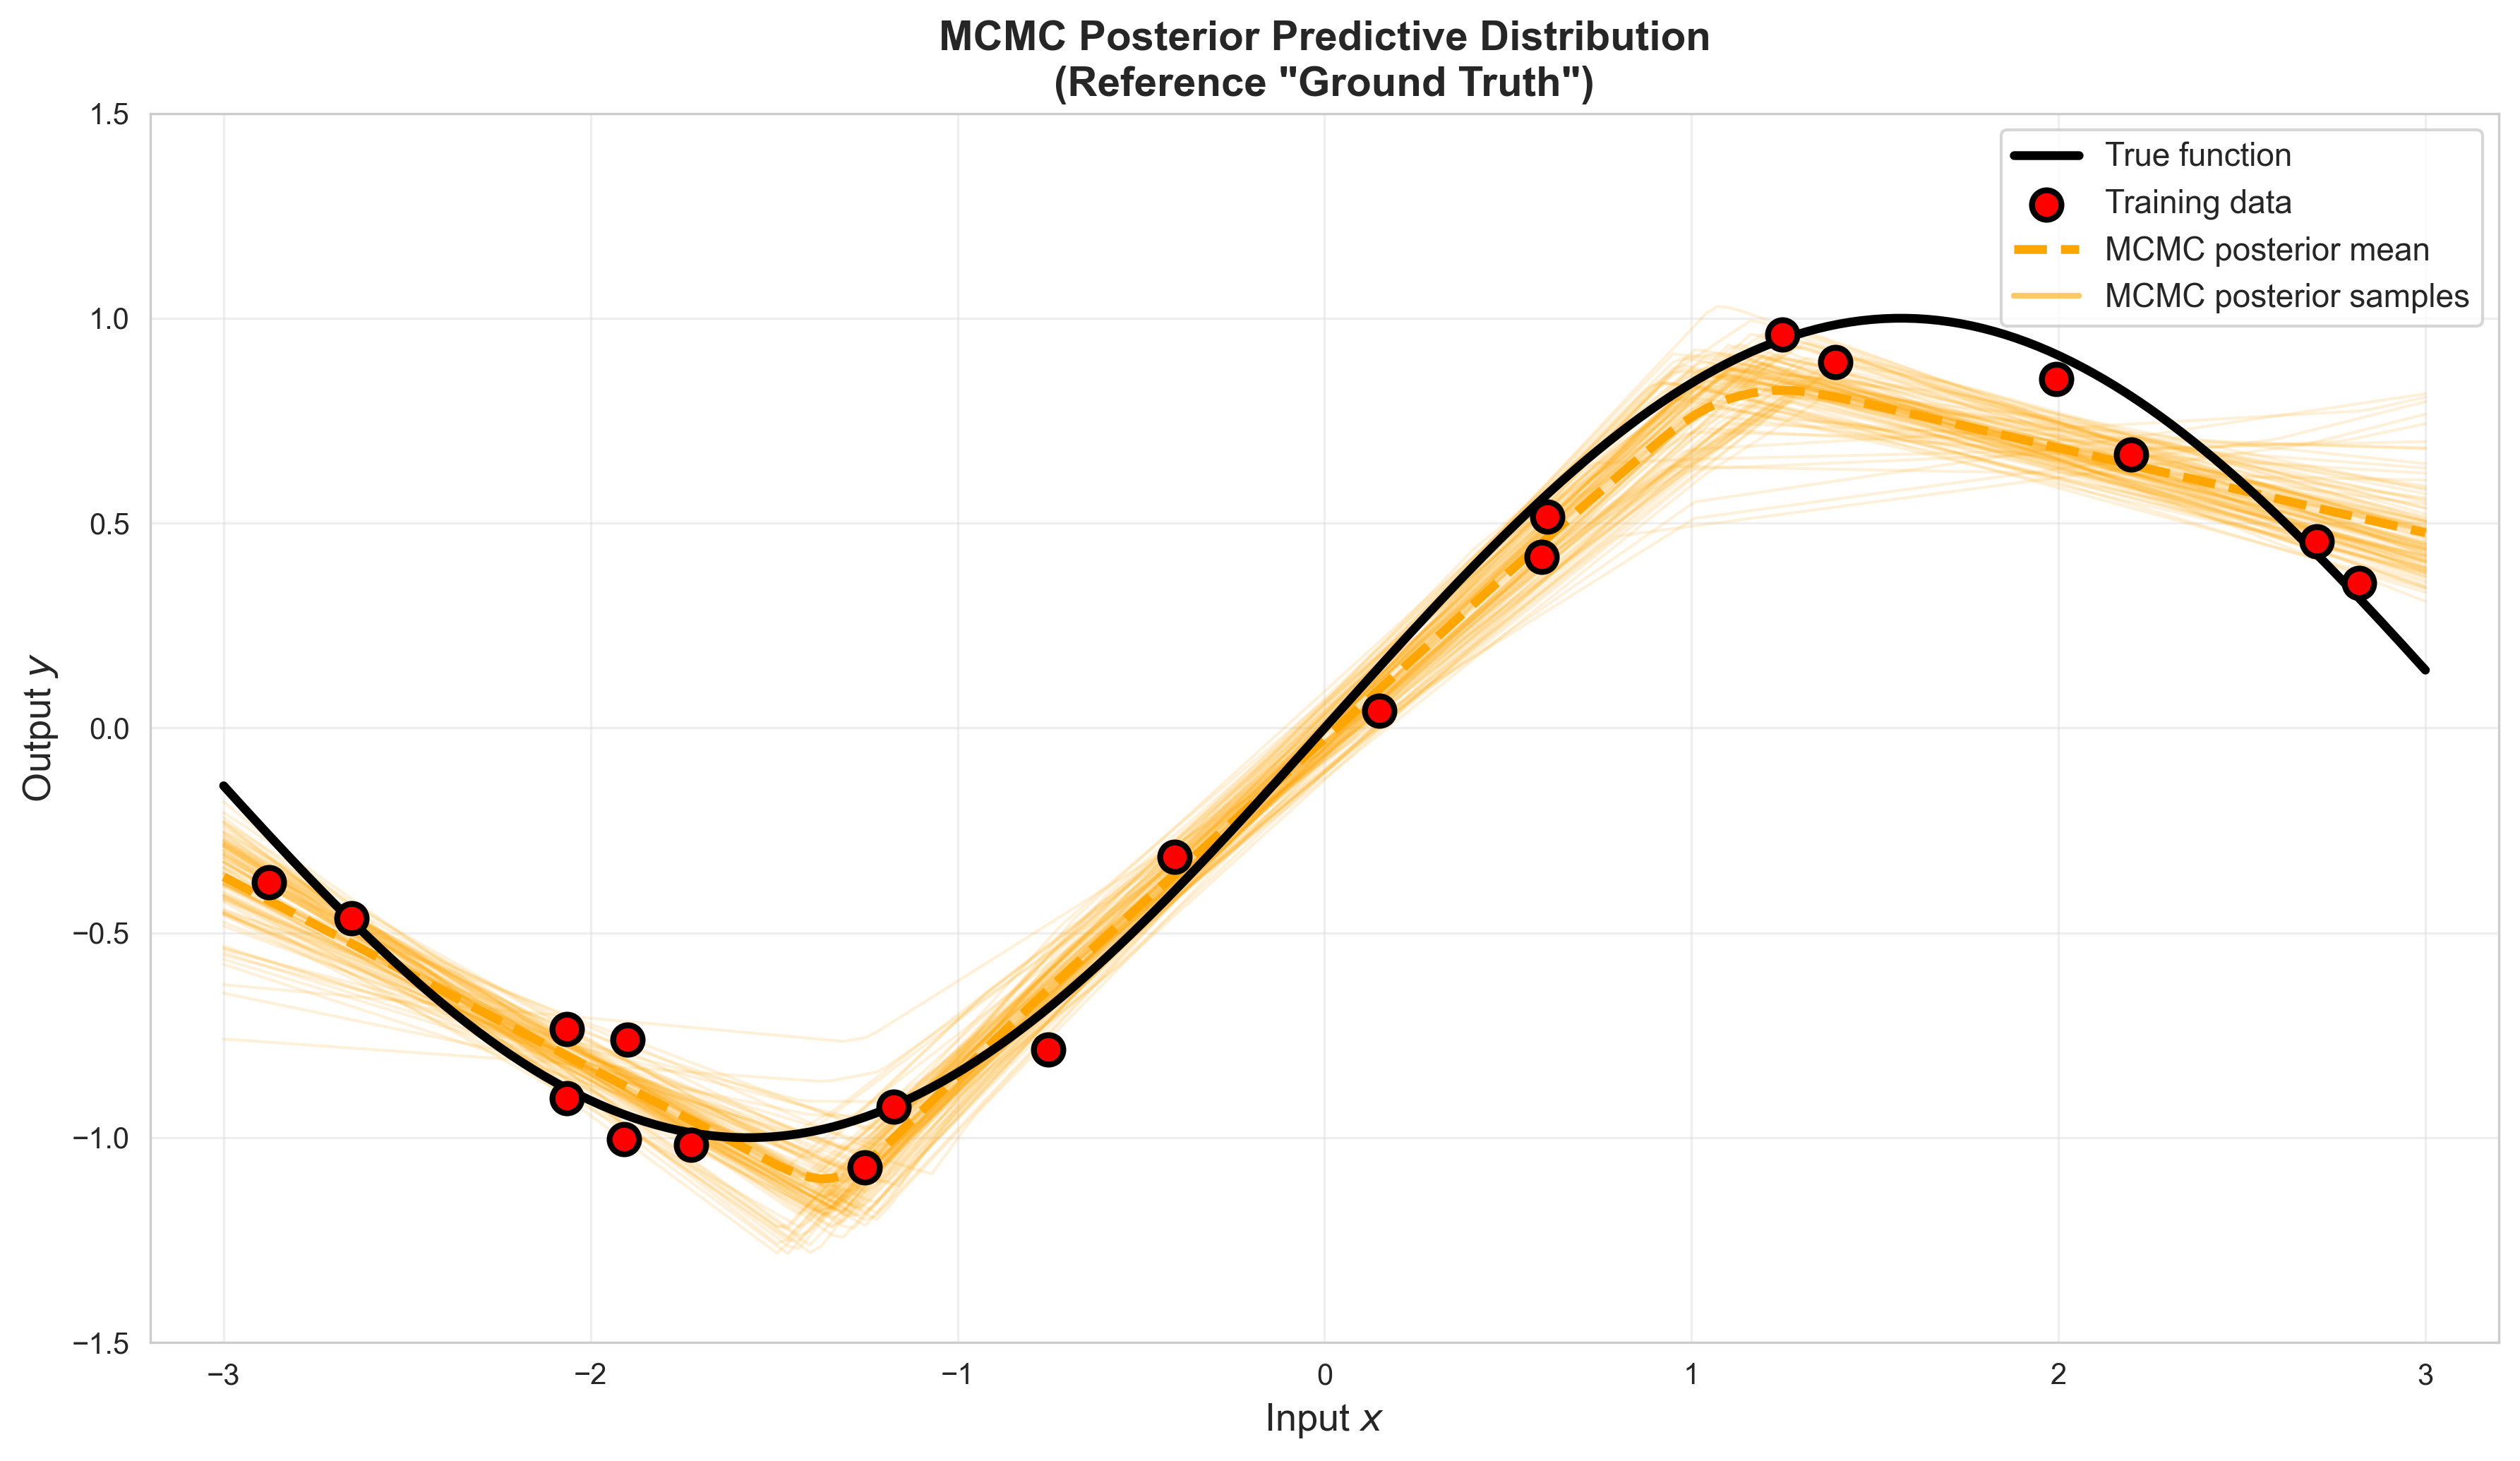

In [8]:
# Visualize MCMC posterior predictive
def predict_with_weight_samples(weight_samples, x_test, n_samples=None):
    """Generate predictions using sampled weights."""
    if n_samples is None:
        n_samples = len(weight_samples)
    
    model_temp = SmallNN(hidden_size=5)
    x_test_tensor = torch.FloatTensor(x_test)
    predictions = []
    
    # Randomly select samples to plot
    sample_indices = np.random.choice(len(weight_samples), size=min(n_samples, len(weight_samples)), replace=False)
    
    with torch.no_grad():
        for idx in sample_indices:
            model_temp.set_weights_flat(torch.FloatTensor(weight_samples[idx]))
            y_pred = model_temp(x_test_tensor).numpy()
            predictions.append(y_pred)
    
    return np.array(predictions)

# Generate MCMC posterior predictions
mcmc_predictions = predict_with_weight_samples(mcmc_samples, x_test, n_samples=100)

# Visualize
fig, ax = plt.subplots(figsize=(12, 7))

# Plot MCMC posterior samples
for i in range(len(mcmc_predictions)):
    ax.plot(x_test, mcmc_predictions[i], 'orange', alpha=0.15, linewidth=1)

# True function and data
ax.plot(x_test, y_test_true, 'k-', linewidth=3, label='True function', zorder=10)
ax.scatter(x_train, y_train, s=100, c='red', edgecolors='black', 
           linewidth=2, zorder=15, label='Training data')

# Posterior mean
mcmc_mean = mcmc_predictions.mean(axis=0)
ax.plot(x_test, mcmc_mean, 'orange', linewidth=3, label='MCMC posterior mean', linestyle='--', zorder=5)

# Dummy line for legend
ax.plot([], [], 'orange', alpha=0.6, linewidth=2, label='MCMC posterior samples')

ax.set_xlabel('Input $x$', fontsize=13)
ax.set_ylabel('Output $y$', fontsize=13)
ax.set_title('MCMC Posterior Predictive Distribution\n(Reference "Ground Truth")', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([-3.2, 3.2])
ax.set_ylim([-1.5, 1.5])

plt.tight_layout()
plt.show()

## Variational Inference for Neural Networks

MCMC works but is slow, since it essentially has to generate thousands of good samples. In constrast, Variational Inference methods turn the **integration** problem into an **optimization** problem. Instead of sampling from $p(\mathbf{w} | X, Y)$, we:

1. Choose a tractable family $q_\phi(\mathbf{w})$ (e.g., Gaussian)
2. Find $\phi$ that makes $q_\phi$ close to the true posterior
3. Measure "closeness" using the **ELBO** (Evidence Lower Bound)

### Chosing a tractable family $q_\phi(\mathbf{w})$

There are many options for this, as we will see in later more advanced notebooks, but for now let's use something simple: a **mean-field Gaussian** approximation:
$$q_\phi(\mathbf{w}) = \mathcal{N}(\boldsymbol{\mu}_\phi, \text{diag}(\boldsymbol{\sigma}_\phi^2))$$

Here, each weight in the network has its own mean and variance, and for our network with `n_params` parameters, we would then optimize both for all weights, leading to $2 \times {n_{params}}$ variational parameters.

But what should we be optimizing, exactly?

### 1. Marginal Likelihood (Evidence)

The goal in Bayesian inference is to compute the **marginal likelihood** (also called the evidence):

$$
p(Y|X) = \int p(Y|X, \mathbf{w})\, p(\mathbf{w})\, d\mathbf{w}
$$

Which sounds fine in theory, but this integral is usually **intractable** for neural networks or other complex models we might be interested in. How can we solve this?

### 2. Introducing a Variational Distribution

We introduce a tractable distribution $q_\phi(\mathbf{w})$ to approximate the true posterior $p(\mathbf{w}|X,Y)$.

We can rewrite the log evidence using $q_\phi$:

$$
\log p(Y|X) = \log \int p(Y|X, \mathbf{w})\, p(\mathbf{w})\, d\mathbf{w}
$$

$$
= \log \int q_\phi(\mathbf{w})\, \frac{p(Y|X, \mathbf{w})\, p(\mathbf{w})}{q_\phi(\mathbf{w})}\, d\mathbf{w}
$$

So far, this mathematical maneuver hasn't really bought us much, but we can apply an approximation to help us separate out some terms.

### 3. Applying Jensen's Inequality

Jensen's Inequality states that, for a convex function $f$:

$$
f(\mathbb{E}[x]) \le \mathbb{E}[f(x)]
$$

and if we apply Jensen's inequality to the above assuming $f=\log$ and $\mathbb{E}=\int$ (note we flip the sign of the inequality since $\log$ is concave, not convex), we get:

$$
\log \mathbb{E}_{q_\phi}\left[\frac{p(Y|X, \mathbf{w})\, p(\mathbf{w})}{q_\phi(\mathbf{w})}\right]
\geq \mathbb{E}_{q_\phi}\left[\log \frac{p(Y|X, \mathbf{w})\, p(\mathbf{w})}{q_\phi(\mathbf{w})}\right]
$$

Now we can bring the log inside to help break out some of the terms and rearrange them.

### 4. The ELBO Expression

This gives us the **Evidence Lower Bound (ELBO)**:

$$
\log p(Y|X) \geq \mathbb{E}_{q_\phi}\left[\log p(Y|X, \mathbf{w})\right]
+ \mathbb{E}_{q_\phi}\left[\log p(\mathbf{w})\right]
- \mathbb{E}_{q_\phi}\left[\log q_\phi(\mathbf{w})\right]
$$

Or, by grouping $\mathbb{E}_{q_\phi}\left[\log p(\mathbf{w})\right]$ and $\mathbb{E}_{q_\phi}\left[\log q_\phi(\mathbf{w})\right]$ into the (negative) KL Divergence:

$$
\mathcal{L}(\phi) = \mathbb{E}_{q_\phi}\left[\log p(Y|X, \mathbf{w})\right]
- \mathrm{KL}\left(q_\phi(\mathbf{w})\,\|\,p(\mathbf{w})\right)
$$

We arrive at the common form of the ELBO, where:

- The **first term** encourages $q_\phi$ to place mass on weights that explain the data well. This is the **Expected log-likelihood** and measures How well $q_\phi$ explains the data.
- The **second term** (the **KL divergence**) regularizes $q_\phi$ to stay close to the prior.

This is the objective we will then optimize when we perform variational inference.


### Note on the Reparameterization Trick

While in principle we should be all good to go with optimizing the ELBO above, you will see that the gradients will end up having to differentiate backward through $\mathbb{E}_{q_\phi}$ which is a stochastic function. This can induce high variance in the gradient updates, and so in practice, we use something called the Reparameterization Trick to reduce variance in the gradients:

$$
\mathbf{w} = \boldsymbol{\mu}_\phi + \boldsymbol{\sigma}_\phi \odot \boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

This decouples the stochasticity needed for the sampling of $\mathbb{E}_{q_\phi}$ from the gradient pathway backward through $\mu_\phi$ and $\sigma_\phi$.

In [9]:
#| code-fold: false
# Variational Inference for Bayesian Neural Network
class BayesianNNVI(nn.Module):
    """
    Bayesian Neural Network with Variational Inference.
    
    Each weight has a variational posterior q(w) = N(mu, sigma^2).
    """
    
    def __init__(self, hidden_size=5):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Variational parameters for layer 1: input -> hidden
        self.fc1_mu_weight = nn.Parameter(torch.randn(hidden_size, 1) * 0.1)
        self.fc1_mu_bias = nn.Parameter(torch.randn(hidden_size) * 0.1)
        self.fc1_logsigma_weight = nn.Parameter(torch.ones(hidden_size, 1) * -3)  # Start with low variance
        self.fc1_logsigma_bias = nn.Parameter(torch.ones(hidden_size) * -3)
        
        # Variational parameters for layer 2: hidden -> output
        self.fc2_mu_weight = nn.Parameter(torch.randn(1, hidden_size) * 0.1)
        self.fc2_mu_bias = nn.Parameter(torch.randn(1) * 0.1)
        self.fc2_logsigma_weight = nn.Parameter(torch.ones(1, hidden_size) * -3)
        self.fc2_logsigma_bias = nn.Parameter(torch.ones(1) * -3)
        
    def sample_weights(self):
        """Sample weights using reparameterization trick."""
        # Layer 1
        fc1_weight = self.fc1_mu_weight + torch.exp(self.fc1_logsigma_weight) * torch.randn_like(self.fc1_mu_weight)
        fc1_bias = self.fc1_mu_bias + torch.exp(self.fc1_logsigma_bias) * torch.randn_like(self.fc1_mu_bias)
        
        # Layer 2
        fc2_weight = self.fc2_mu_weight + torch.exp(self.fc2_logsigma_weight) * torch.randn_like(self.fc2_mu_weight)
        fc2_bias = self.fc2_mu_bias + torch.exp(self.fc2_logsigma_bias) * torch.randn_like(self.fc2_mu_bias)
        
        return (fc1_weight, fc1_bias, fc2_weight, fc2_bias)
    
    def forward(self, x, sample=True):
        """Forward pass with sampled or mean weights."""
        x = x.view(-1, 1)
        
        if sample:
            fc1_w, fc1_b, fc2_w, fc2_b = self.sample_weights()
        else:
            fc1_w, fc1_b = self.fc1_mu_weight, self.fc1_mu_bias
            fc2_w, fc2_b = self.fc2_mu_weight, self.fc2_mu_bias
        
        # Forward propagation
        h = F.relu(F.linear(x, fc1_w, fc1_b))
        y = F.linear(h, fc2_w, fc2_b)
        
        return y.squeeze()
    
    def kl_divergence(self, prior_std=1.0):
        """Compute KL(q||p) where p is N(0, prior_std^2)."""
        kl = 0
        
        # KL for each parameter: KL(N(mu, sigma^2) || N(0, prior_std^2))
        for mu_param, logsigma_param in [
            (self.fc1_mu_weight, self.fc1_logsigma_weight),
            (self.fc1_mu_bias, self.fc1_logsigma_bias),
            (self.fc2_mu_weight, self.fc2_logsigma_weight),
            (self.fc2_mu_bias, self.fc2_logsigma_bias)
        ]:
            sigma = torch.exp(logsigma_param)
            kl += 0.5 * torch.sum(
                (mu_param**2 + sigma**2) / prior_std**2 - 1 - 2*logsigma_param + 2*np.log(prior_std)
            )
        
        return kl
    
    def elbo(self, x, y, n_samples=5, noise_std=0.1, prior_std=1.0):
        """
        Compute the Evidence Lower Bound.
        
        ELBO = E_q[log p(y|x,w)] - KL(q||p)
        """
        x = x.view(-1, 1)
        
        # Expected log-likelihood (Monte Carlo estimate)
        log_lik = 0
        for _ in range(n_samples):
            y_pred = self.forward(x, sample=True)
            log_lik += -0.5 * torch.sum(((y - y_pred) / noise_std) ** 2)
        log_lik = log_lik / n_samples
        log_lik -= len(y) * np.log(noise_std * np.sqrt(2 * np.pi))
        
        # KL divergence
        kl = self.kl_divergence(prior_std)
        
        # ELBO
        elbo = log_lik - kl
        
        return elbo, log_lik, kl

# Initialize variational model
vi_model = BayesianNNVI(hidden_size=5)

print("Bayesian NN with Variational Inference initialized")
# Uncomment below if you would like a listing of all parameters and counts:
# print("Variational parameters:")
# for name, param in vi_model.named_parameters():
#     print(f"  {name}: shape {param.shape}")
#     n_var_params = sum(p.numel() for p in vi_model.parameters())
#     print(f"Total variational parameters: {n_var_params}")
#     print("(2x the number of network weights for mean + variance)")

Bayesian NN with Variational Inference initialized


In [10]:
# Train with Variational Inference
vi_model = BayesianNNVI(hidden_size=5)
optimizer = torch.optim.Adam(vi_model.parameters(), lr=0.01)

x_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.FloatTensor(y_train)

n_epochs = 3000
n_mc_samples = 5  # Monte Carlo samples per ELBO evaluation

history = {
    'elbo': [],
    'log_lik': [],
    'kl': []
}

print("Training Bayesian NN with Variational Inference...")
print(f"Epochs: {n_epochs}, MC samples: {n_mc_samples}")

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Compute ELBO (negative for minimization)
    elbo, log_lik, kl = vi_model.elbo(x_train_tensor, y_train_tensor, 
                                       n_samples=n_mc_samples, 
                                       noise_std=noise_std, 
                                       prior_std=1.0)
    loss = -elbo  # Maximize ELBO = minimize negative ELBO
    
    # Backprop and update
    loss.backward()
    optimizer.step()
    
    # Track metrics
    history['elbo'].append(elbo.item())
    history['log_lik'].append(log_lik.item())
    history['kl'].append(kl.item())
    
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1:4d} | ELBO: {elbo.item():8.2f} | "
              f"Log-lik: {log_lik.item():8.2f} | KL: {kl.item():6.2f}")
print("Training complete!")

Training Bayesian NN with Variational Inference...
Epochs: 3000, MC samples: 5
Epoch  500 | ELBO:   -51.02 | Log-lik:    -6.08 | KL:  44.94
Epoch  500 | ELBO:   -51.02 | Log-lik:    -6.08 | KL:  44.94
Epoch 1000 | ELBO:   -31.99 | Log-lik:    13.25 | KL:  45.25
Epoch 1000 | ELBO:   -31.99 | Log-lik:    13.25 | KL:  45.25
Epoch 1500 | ELBO:   -31.65 | Log-lik:    14.56 | KL:  46.21
Epoch 1500 | ELBO:   -31.65 | Log-lik:    14.56 | KL:  46.21
Epoch 2000 | ELBO:   -26.31 | Log-lik:    20.06 | KL:  46.36
Epoch 2000 | ELBO:   -26.31 | Log-lik:    20.06 | KL:  46.36
Epoch 2500 | ELBO:   -31.36 | Log-lik:    14.67 | KL:  46.03
Epoch 2500 | ELBO:   -31.36 | Log-lik:    14.67 | KL:  46.03
Epoch 3000 | ELBO:   -27.71 | Log-lik:    18.08 | KL:  45.78
Training complete!
Epoch 3000 | ELBO:   -27.71 | Log-lik:    18.08 | KL:  45.78
Training complete!


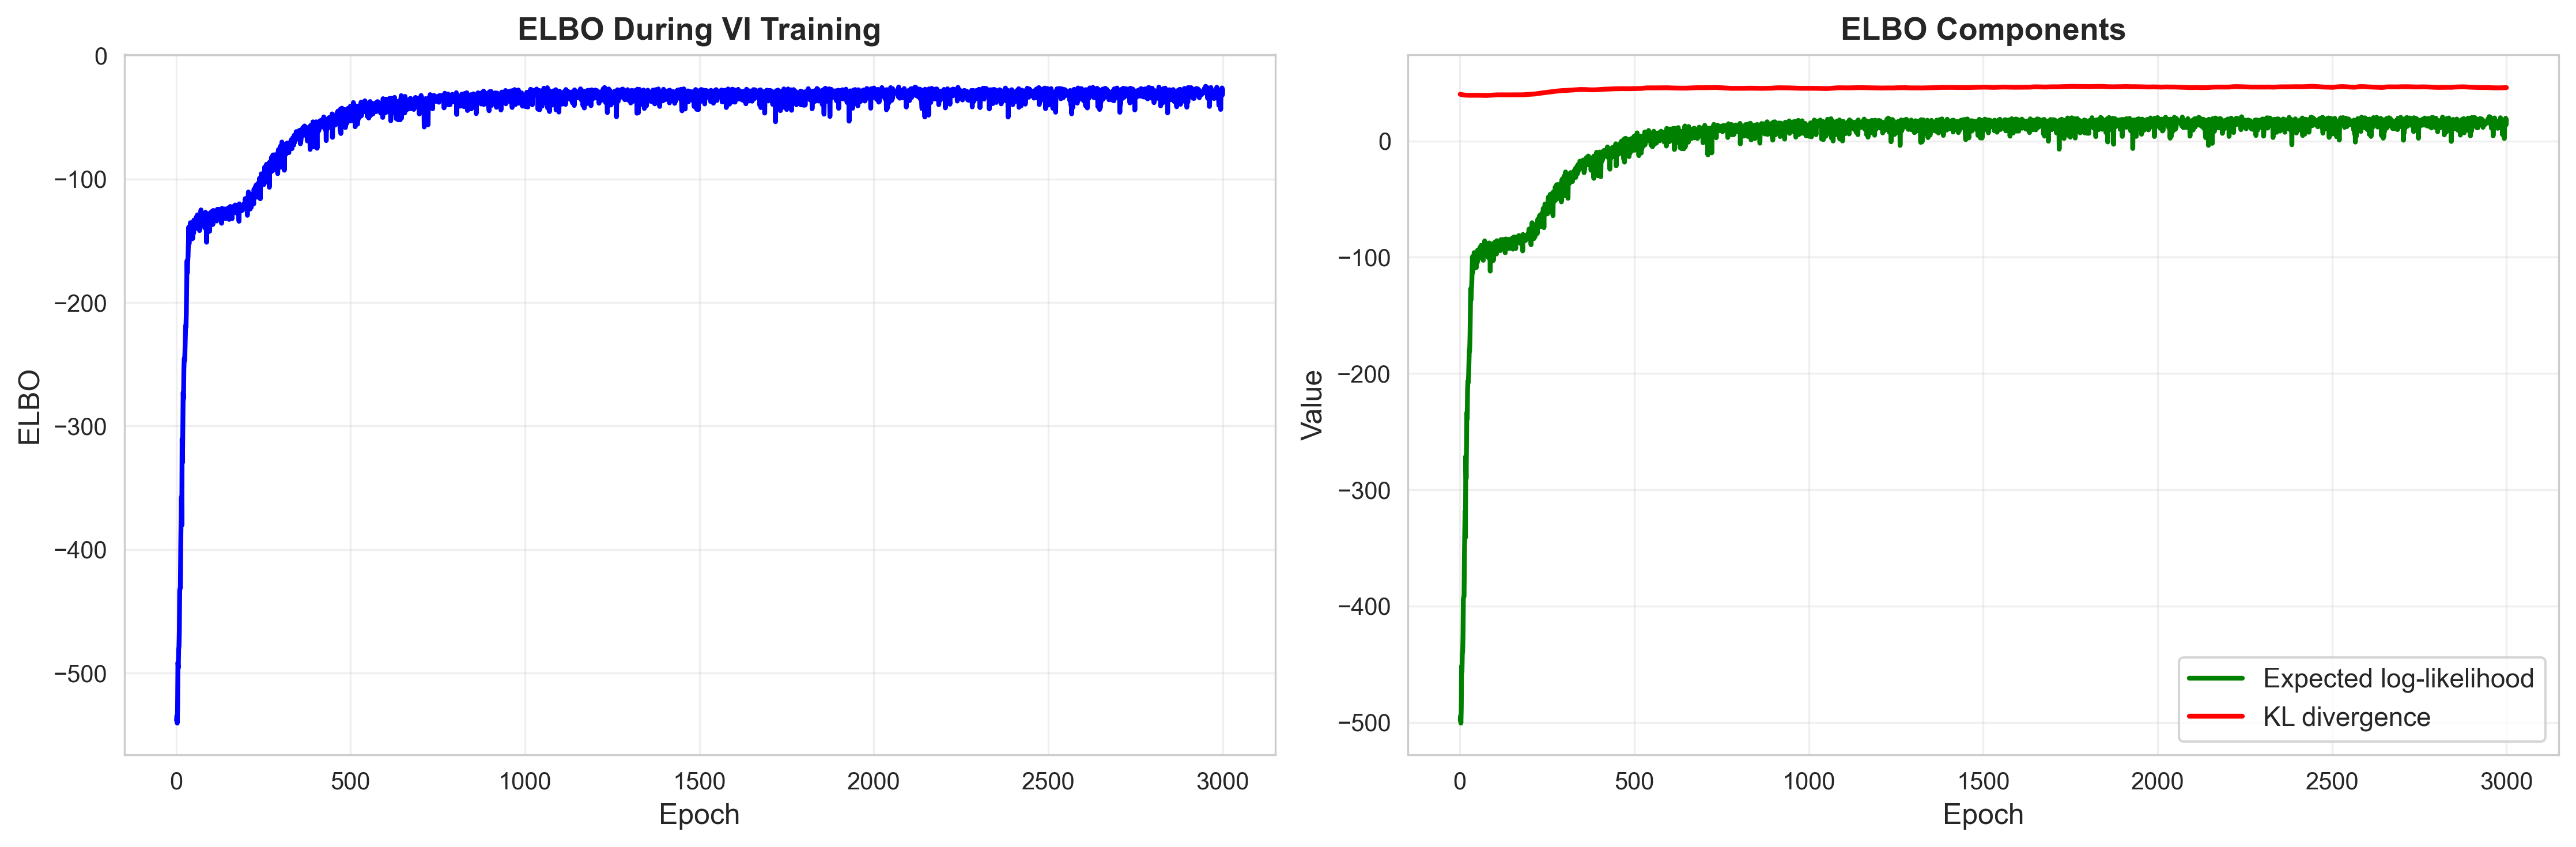

Final ELBO breakdown:
  ELBO: -27.71
  Expected log-likelihood: 18.08
  KL divergence: 45.78


In [11]:
# Visualize VI training progress
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs_arr = np.arange(1, len(history['elbo']) + 1)

# Plot 1: ELBO over time
ax = axes[0]
ax.plot(epochs_arr, history['elbo'], linewidth=2, color='blue')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('ELBO', fontsize=12)
ax.set_title('ELBO During VI Training', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: ELBO components
ax = axes[1]
ax.plot(epochs_arr, history['log_lik'], linewidth=2, label='Expected log-likelihood', color='green')
ax.plot(epochs_arr, history['kl'], linewidth=2, label='KL divergence', color='red')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('ELBO Components', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Final ELBO breakdown:")
print(f"  ELBO: {history['elbo'][-1]:.2f}")
print(f"  Expected log-likelihood: {history['log_lik'][-1]:.2f}")
print(f"  KL divergence: {history['kl'][-1]:.2f}")

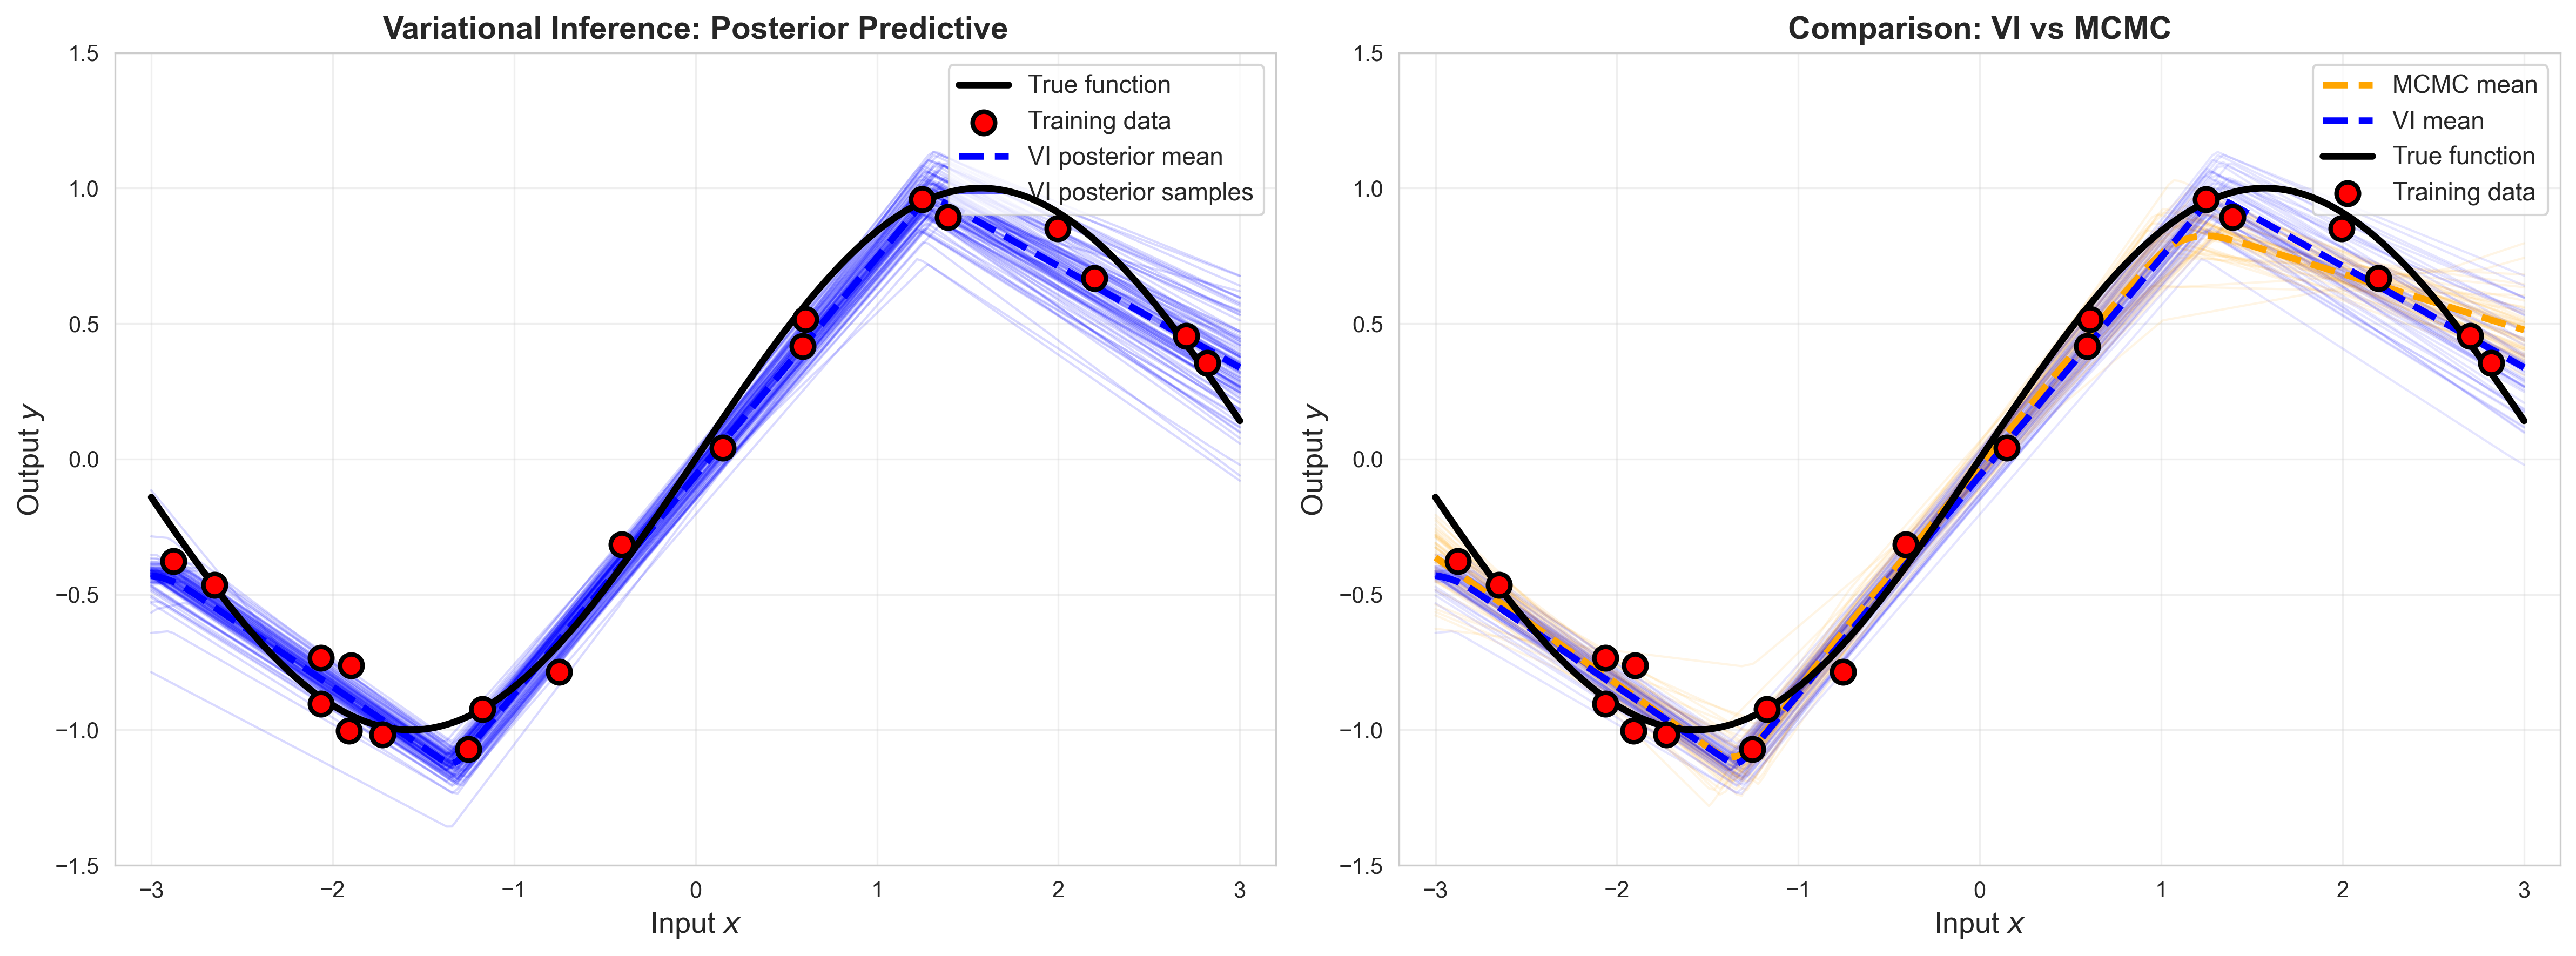

In [12]:
# Generate VI posterior predictive samples
x_test_tensor = torch.FloatTensor(x_test)
vi_predictions = []

with torch.no_grad():
    for _ in range(100):
        y_pred = vi_model(x_test_tensor, sample=True).numpy()
        vi_predictions.append(y_pred)

vi_predictions = np.array(vi_predictions)
vi_mean = vi_predictions.mean(axis=0)
vi_std = vi_predictions.std(axis=0)

# Compare VI vs MCMC
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: VI Posterior Predictive
ax = axes[0]

# VI samples
for i in range(len(vi_predictions)):
    ax.plot(x_test, vi_predictions[i], 'blue', alpha=0.15, linewidth=1)

# True function and data
ax.plot(x_test, y_test_true, 'k-', linewidth=3, label='True function', zorder=10)
ax.scatter(x_train, y_train, s=100, c='red', edgecolors='black', 
           linewidth=2, zorder=15, label='Training data')

# VI mean
ax.plot(x_test, vi_mean, 'blue', linewidth=3, label='VI posterior mean', linestyle='--', zorder=5)

# Dummy line for legend
ax.plot([], [], 'blue', alpha=0.6, linewidth=2, label='VI posterior samples')

ax.set_xlabel('Input $x$', fontsize=13)
ax.set_ylabel('Output $y$', fontsize=13)
ax.set_title('Variational Inference: Posterior Predictive', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([-3.2, 3.2])
ax.set_ylim([-1.5, 1.5])

# Plot 2: Direct comparison VI vs MCMC
ax = axes[1]

# MCMC samples (lighter)
for i in range(min(50, len(mcmc_predictions))):
    ax.plot(x_test, mcmc_predictions[i], 'orange', alpha=0.1, linewidth=1)

# VI samples (darker)
for i in range(50):
    ax.plot(x_test, vi_predictions[i], 'blue', alpha=0.1, linewidth=1)

# Means
ax.plot(x_test, mcmc_mean, 'orange', linewidth=3, label='MCMC mean', linestyle='--')
ax.plot(x_test, vi_mean, 'blue', linewidth=3, label='VI mean', linestyle='--')

# True function and data
ax.plot(x_test, y_test_true, 'k-', linewidth=3, label='True function', zorder=10)
ax.scatter(x_train, y_train, s=100, c='red', edgecolors='black', 
           linewidth=2, zorder=15, label='Training data')

ax.set_xlabel('Input $x$', fontsize=13)
ax.set_ylabel('Output $y$', fontsize=13)
ax.set_title('Comparison: VI vs MCMC', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([-3.2, 3.2])
ax.set_ylim([-1.5, 1.5])

plt.tight_layout()
plt.show()

Note the difference in training times between the MCMC Method and VI Method. The main thing we give up for this increase in speed is the

## Possible Experiments
Now that you understand the full pipeline, you can explore below how some of the fundamental parameters of the model might affect the results:

::: {.callout-tip appearance="default"}
### Experiment 1: Vary Hidden Layer Size

Train VI models with `hidden_size` = 2, 5, 10, 20. Observe:
- How does model flexibility change?
- Does uncertainty increase or decrease?
- Is there a risk of overfitting with larger networks?
:::

::: {.callout-tip appearance="default"}
### Experiment 2: Effect of Training Data Size

Generate datasets with `n_train` = 5, 10, 20, 50. For each:
- Train the VI model
- Plot posterior predictive distributions
- Compare the model uncertainty in data-rich vs data-sparse regions What do you notice?

:::

::: {.callout-tip appearance="default"}
### Experiment 3: Prior Sensitivity

Try different prior standard deviations: `prior_std` = 0.1, 1.0, 10.0. Observe:
- How does this affect the learned posterior?
- Does a strong prior (small std) regularize more?
- What happens with a weak prior (large std)?

:::

We can do Experiment 1 together as an example, and leave the remainder for you to do independently:

In [13]:
# Experiment 1: Vary hidden layer size
hidden_sizes_to_test = [2, 5, 10, 20]
results_by_size = {}

print("Experiment 1: Effect of Hidden Layer Size")
print("Training VI models with different architectures...")

for h_size in hidden_sizes_to_test:
    print(f"Training with hidden_size = {h_size}...")
    
    # Initialize and train
    model_exp = BayesianNNVI(hidden_size=h_size)
    optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=0.01)
    
    for epoch in range(2000):
        optimizer_exp.zero_grad()
        elbo, _, _ = model_exp.elbo(x_train_tensor, y_train_tensor, 
                                     n_samples=5, noise_std=noise_std, prior_std=1.0)
        loss = -elbo
        loss.backward()
        optimizer_exp.step()
    
    # Generate predictions
    predictions = []
    with torch.no_grad():
        for _ in range(100):
            y_pred = model_exp(x_test_tensor, sample=True).numpy()
            predictions.append(y_pred)
    
    predictions = np.array(predictions)
    results_by_size[h_size] = {
        'predictions': predictions,
        'mean': predictions.mean(axis=0),
        'std': predictions.std(axis=0)
    }
    
    print(f"  Final ELBO: {elbo.item():.2f}")

print("Training complete!")

Experiment 1: Effect of Hidden Layer Size
Training VI models with different architectures...
Training with hidden_size = 2...
  Final ELBO: -104.90
Training with hidden_size = 5...
  Final ELBO: -104.90
Training with hidden_size = 5...
  Final ELBO: -32.13
Training with hidden_size = 10...
  Final ELBO: -32.13
Training with hidden_size = 10...
  Final ELBO: -45.72
Training with hidden_size = 20...
  Final ELBO: -45.72
Training with hidden_size = 20...
  Final ELBO: -76.40
Training complete!
  Final ELBO: -76.40
Training complete!


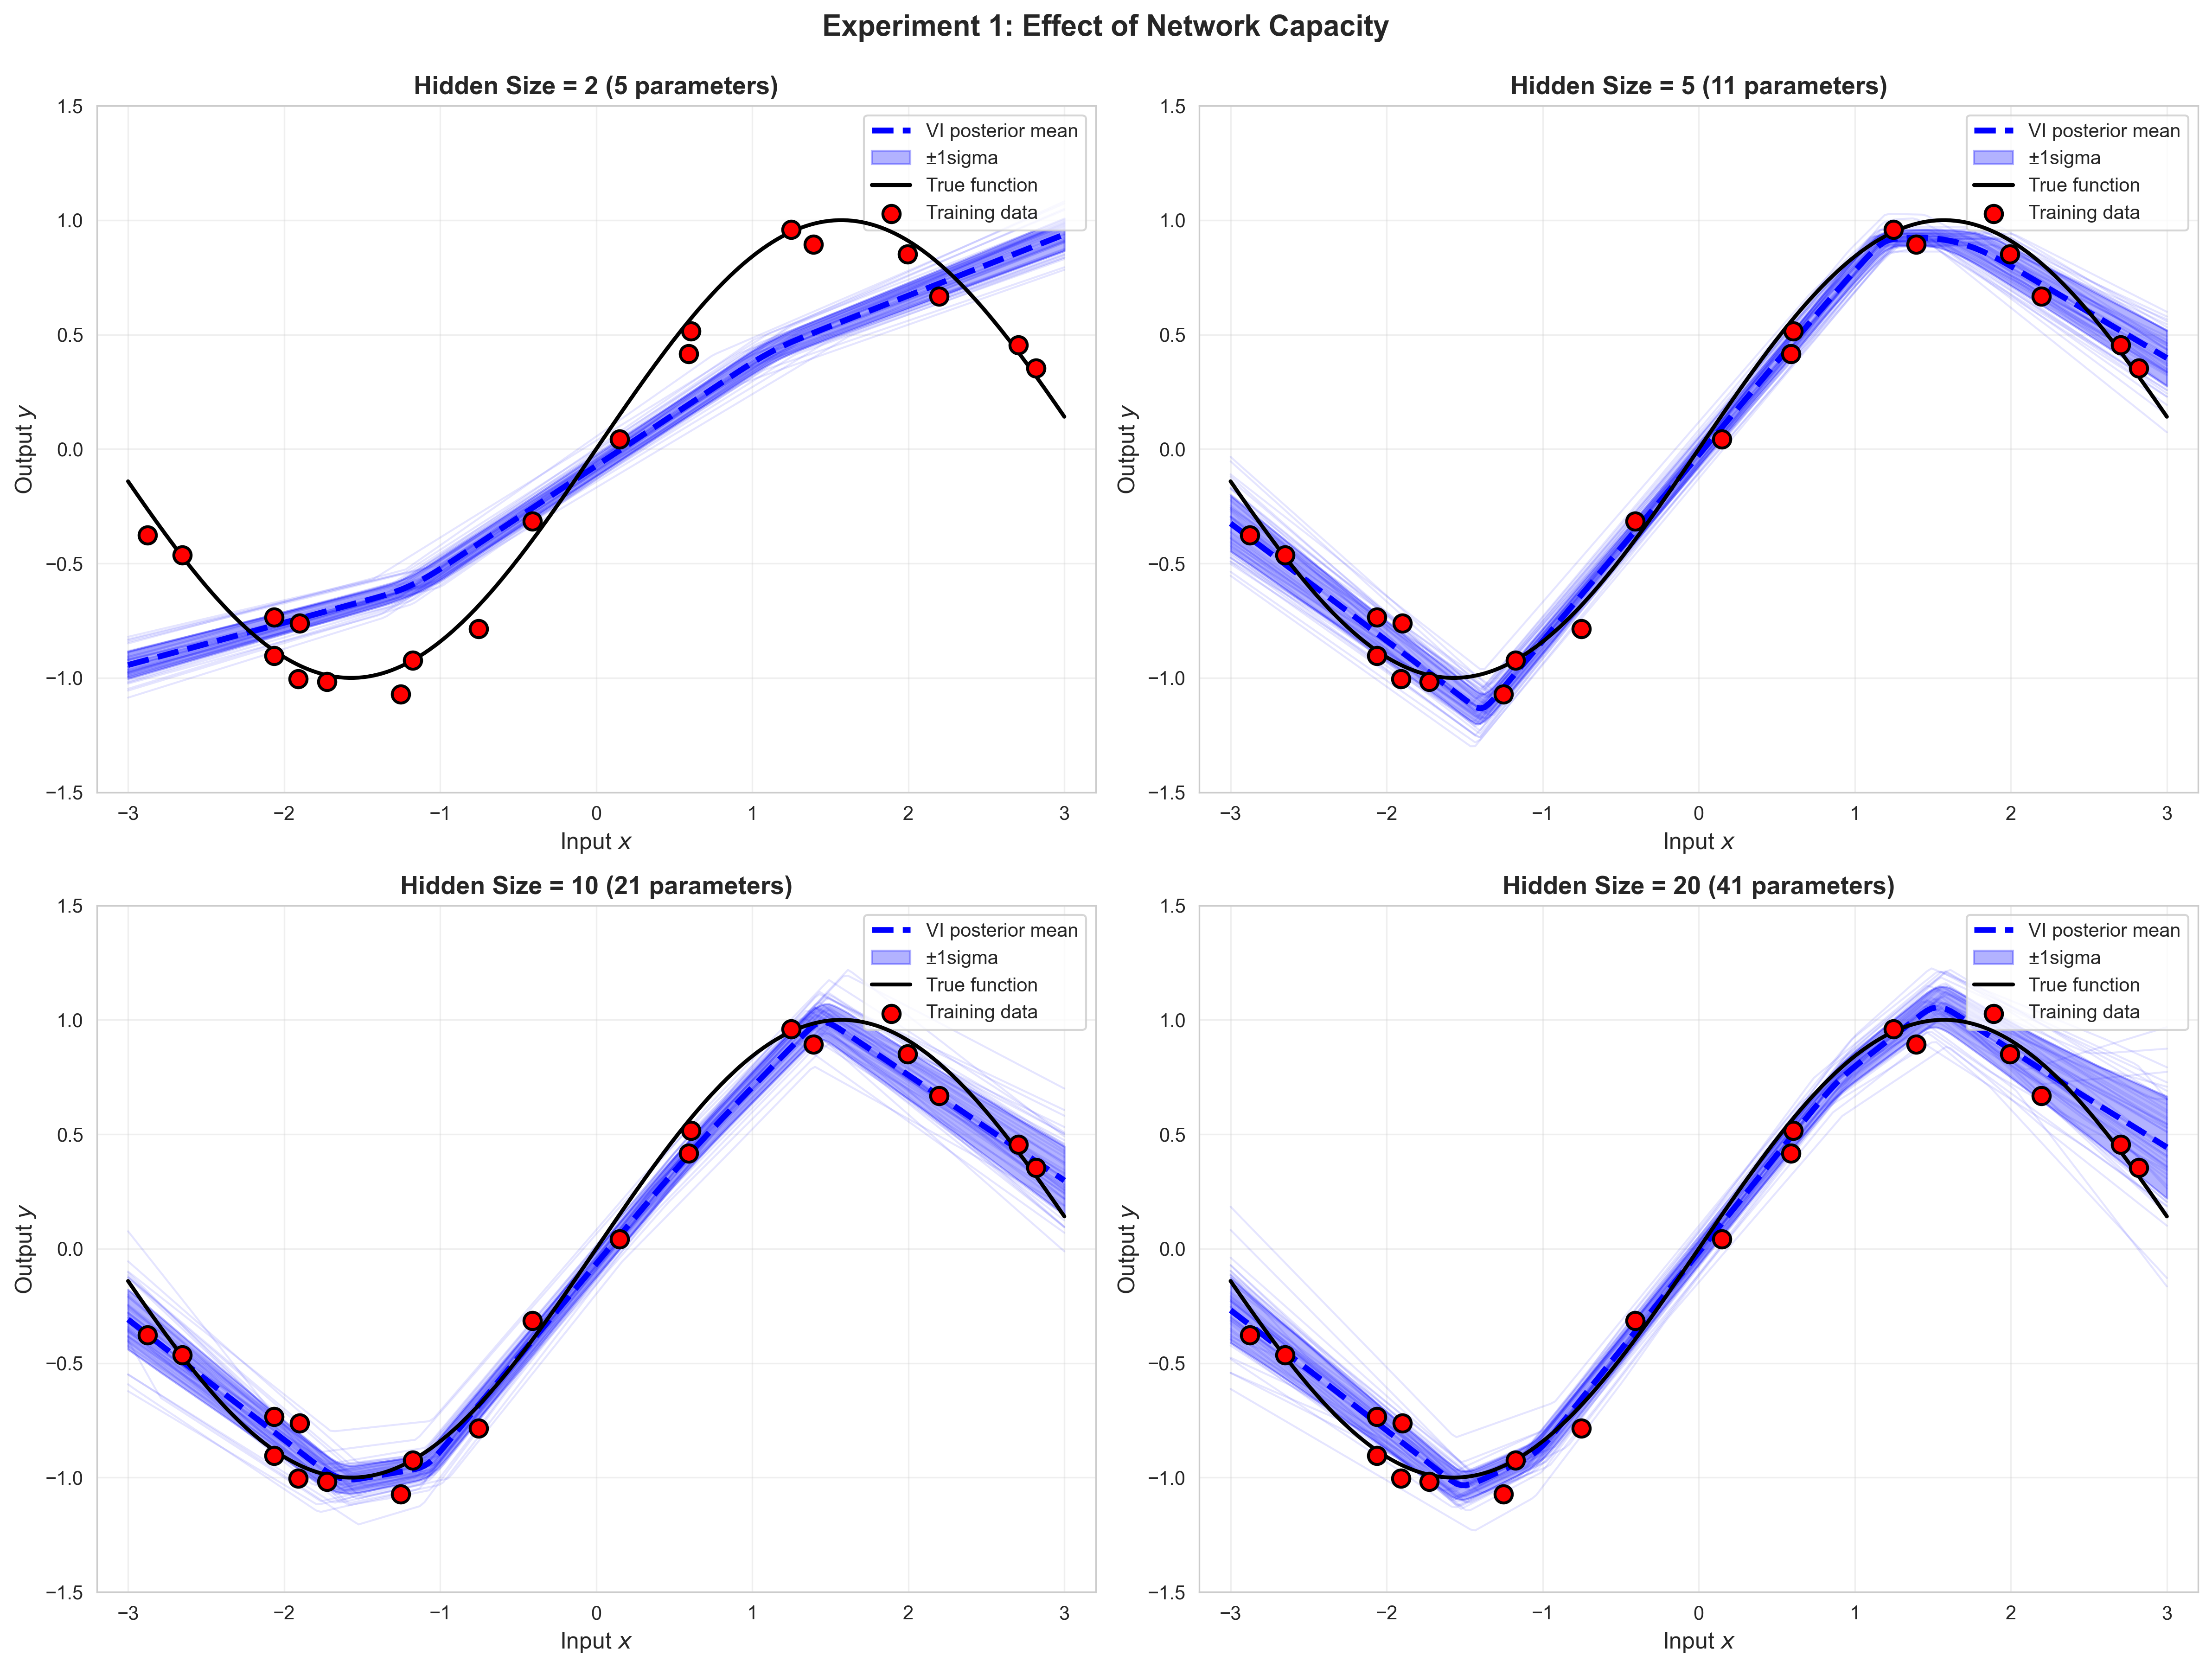

In [14]:
# Visualize results from Experiment 1
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, h_size in enumerate(hidden_sizes_to_test):
    ax = axes[idx]
    
    result = results_by_size[h_size]
    
    # Plot posterior samples
    for i in range(min(50, len(result['predictions']))):
        ax.plot(x_test, result['predictions'][i], 'blue', alpha=0.1, linewidth=1)
    
    # Plot mean and uncertainty bands
    ax.plot(x_test, result['mean'], 'blue', linewidth=3, label='VI posterior mean', linestyle='--')
    ax.fill_between(x_test, 
                     result['mean'] - result['std'], 
                     result['mean'] + result['std'],
                     alpha=0.3, color='blue', label='±1sigma')
    
    # True function and data
    ax.plot(x_test, y_test_true, 'k-', linewidth=2, label='True function', zorder=10)
    ax.scatter(x_train, y_train, s=80, c='red', edgecolors='black', 
               linewidth=1.5, zorder=15, label='Training data')
    
    ax.set_xlabel('Input $x$', fontsize=12)
    ax.set_ylabel('Output $y$', fontsize=12)
    ax.set_title(f'Hidden Size = {h_size} ({(h_size+1) + h_size} parameters)', 
                 fontsize=13, fontweight='bold')
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([-3.2, 3.2])
    ax.set_ylim([-1.5, 1.5])

plt.suptitle('Experiment 1: Effect of Network Capacity', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Summary and the bridge to VAEs

We saw a few key takeaways in this notebook:

### 1. **Bayesian Inference Quantifies Uncertainty**
- Instead of a single "best" model, we maintain a distribution over models
- The **posterior predictive distribution** $p(y_* | x_*, X, Y)$ gives us predictions **with uncertainty**

### 2. **Linear Models Have Limitations**
- **Bayesian linear regression** has exact, closed-form posteriors (Gaussian)
- This allows us to compute predictive mean and variance analytically
- However, they cannot capture nonlinear relationships, as we saw in this example

### 3. **Neural Networks Provide Flexibility at the cost of an intractable posterior**
- Even a small 1-hidden-layer network can approximate complex functions
- **Prior predictive** shows diverse possible functions before seeing data
- **Challenge**: Posterior $p(\mathbf{w} | X, Y)$ is no longer tractable.

### 4. **MCMC: Accurate but Slow**
- Markov Chain Monte Carlo samples from the true posterior
- **Pros**: Asymptotically exact, unbiased
- **Cons**: Computationally expensive, slow for high-dimensional models
- Useful as a **reference** for validation

### 5. **Variational Inference: Fast Approximation**
- Approximate $p(\mathbf{w} | X, Y)$ with a tractable family $q_\phi(\mathbf{w})$
- Optimize $\phi$ to maximize the **ELBO**:
  $$\mathcal{L}(\phi) = \mathbb{E}_{q_\phi}\left[\log p(Y | X, \mathbf{w})\right] - \text{KL}(q_\phi(\mathbf{w}) || p(\mathbf{w}))$$
- **Reparameterization trick** enables low-variance gradient estimates
- **Result**: Posterior approximation in seconds instead of minutes

### 6. **Function Space vs Weight Space**
- We don't visualize high-dimensional weight distributions directly
- Instead, we visualize **functions** sampled from the posterior
- **Posterior predictive** is what matters for making predictions!


### Looking forward to VAEs (Variational Autoencoders)

The VI approach you learned here is the **same mathematical foundation** for VAEs. The key differences are:

- **Here (Bayesian NN)**: Posterior over **weights** $p(\mathbf{w} | X, Y)$
- **VAEs**: Posterior over **latent variables** $p(\mathbf{z} | \mathbf{x})$

The ELBO, reparameterization trick, and optimization strategy are identical.

Moreover, in VAEs, instead of optimizing $q_\phi(z)$ separately for each datapoint $x$, we learn an **encoder network** $q_\phi(z | x)$ that works for **all** $x$. This is called **amortized inference**.

### Stochastic VI

For very large datasets, we can use **mini-batches** and stochastic optimization, much like we did for gradient descent, to scale VI to millions of datapoints.

**Questions to Reflect on**

Think about these before moving to the next notebook:

1. **Why does VI underestimate uncertainty?**  
   Hint: Is the Mean-field approximation where we assume independence between weights reasonable? When might it not be?

2. **When would MCMC be essential despite being slow?**  
   
3. **Could we use a more expressive variational family?**  
   We used a Mean-field Gaussian here, but are we limited to this?
